#Data Handling

##Importing

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from timeit import default_timer as timers
import pickle
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, r2_score

<ipython-input-123-7131fa4b9850>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Loading

In [ ]:
# Define the file path (update this to the correct path of your file)
file_path = '/content/drive/MyDrive/Kp_ap_Ap_SN_F107_since_1932.txt'

# Define the column names based on the data format
column_names = [
    'Year', 'Month', 'Day', 'Days', 'Days_Mid', 'BSR', 'dB', 'Kp1', 'Kp2', 'Kp3', 'Kp4', 'Kp5', 'Kp6', 'Kp7', 'Kp8',
    'ap1', 'ap2', 'ap3', 'ap4', 'ap5', 'ap6', 'ap7', 'ap8', 'Ap', 'SN', 'F10.7obs', 'F10.7adj', 'D'
]

# Read the file
data = pd.read_csv(file_path, delim_whitespace=True, skiprows=40, header=None, names=column_names)

# Drop the ap_ columns
data = data.drop(columns=['ap1', 'ap2', 'ap3', 'ap4', 'ap5', 'ap6', 'ap7', 'ap8'])

# Display the first few rows of the dataframe without ap_ columns
print(data.head())


   Year  Month  Day  Days  Days_Mid   BSR  dB    Kp1    Kp2    Kp3    Kp4  \
0  1932      1    1     0       0.5  1352  10  3.333  2.667  2.333  2.667   
1  1932      1    2     1       1.5  1352  11  3.667  3.667  3.333  3.667   
2  1932      1    3     2       2.5  1352  12  3.333  3.333  3.000  1.000   
3  1932      1    4     3       3.5  1352  13  2.000  0.333  1.000  0.000   
4  1932      1    5     4       4.5  1352  14  0.000  0.000  0.333  0.667   

     Kp5    Kp6    Kp7    Kp8  Ap  SN  F10.7obs  F10.7adj  D  
0  3.333  2.667  3.333  3.333  15  22      -1.0      -1.0  2  
1  3.333  4.667  3.000  5.000  26  43      -1.0      -1.0  2  
2  2.333  1.667  2.667  2.000  11  23      -1.0      -1.0  2  
3  1.000  1.333  1.333  1.000   4  13      -1.0      -1.0  2  
4  0.333  1.333  1.333  2.000   3  13      -1.0      -1.0  2  


In [ ]:
# prompt: count the rows of a pd

num_rows = data.shape[0]
print("Number of rows:", num_rows)


Number of rows: 33791


##Calculating Mean Values

In [ ]:
# Create a datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Set the datetime column as the index
data.set_index('Date', inplace=True)

# Drop the original Year, Month, Day columns as they are no longer needed
data.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Calculate the daily mean of Kp indices
data['Kp_mean'] = data[['Kp1', 'Kp2', 'Kp3', 'Kp4', 'Kp5', 'Kp6', 'Kp7', 'Kp8']].mean(axis=1)

# Drop the individual Kp columns after calculating the daily mean
data.drop(columns=['Kp1', 'Kp2', 'Kp3', 'Kp4', 'Kp5', 'Kp6', 'Kp7', 'Kp8'], inplace=True)

# Resample the data to a monthly frequency and calculate the mean for each month
monthly_mean_data = data.resample('M').mean()

# Display the first few rows of the monthly mean data
print(monthly_mean_data.head())


             Days  Days_Mid          BSR         dB         Ap         SN  \
Date                                                                        
1932-01-31   15.0      15.5  1352.419355  13.677419  11.000000  20.064516   
1932-02-29   45.0      45.5  1353.517241  14.034483  11.620690  17.620690   
1932-03-31   75.0      75.5  1354.612903  14.451613  18.322581  18.806452   
1932-04-30  105.5     106.0  1355.733333  14.700000  17.300000  18.666667   
1932-05-31  136.0     136.5  1356.838710  15.354839  14.580645  29.741935   

            F10.7obs  F10.7adj    D   Kp_mean  
Date                                           
1932-01-31      -1.0      -1.0  2.0  2.057778  
1932-02-29      -1.0      -1.0  2.0  2.156599  
1932-03-31      -1.0      -1.0  2.0  2.748633  
1932-04-30      -1.0      -1.0  2.0  2.844463  
1932-05-31      -1.0      -1.0  2.0  2.346774  


In [ ]:
# prompt: count the rows of a pd

num_rows = monthly_mean_data.shape[0]
print("Number of rows:", num_rows)


Number of rows: 1111


##Fixing day

In [ ]:
# Resample monthly_mean_data to ensure each date is represented as the 1st of the month
monthly_mean_data.index = monthly_mean_data.index.to_period('M').to_timestamp()

print(monthly_mean_data.head())

             Days  Days_Mid          BSR         dB         Ap         SN  \
Date                                                                        
1932-01-01   15.0      15.5  1352.419355  13.677419  11.000000  20.064516   
1932-02-01   45.0      45.5  1353.517241  14.034483  11.620690  17.620690   
1932-03-01   75.0      75.5  1354.612903  14.451613  18.322581  18.806452   
1932-04-01  105.5     106.0  1355.733333  14.700000  17.300000  18.666667   
1932-05-01  136.0     136.5  1356.838710  15.354839  14.580645  29.741935   

            F10.7obs  F10.7adj    D   Kp_mean  
Date                                           
1932-01-01      -1.0      -1.0  2.0  2.057778  
1932-02-01      -1.0      -1.0  2.0  2.156599  
1932-03-01      -1.0      -1.0  2.0  2.748633  
1932-04-01      -1.0      -1.0  2.0  2.844463  
1932-05-01      -1.0      -1.0  2.0  2.346774  


##Importing Df

In [ ]:
import pandas as pd

# Define column names based on the description
column_names = ['Year', 'Month', 'Date_Fraction', 'Sunspots_Number', 'St_Deviation', 'Nobs', 'Indicator']

# Read the CSV file and add column names
df = pd.read_csv('/content/drive/MyDrive/Monthly_Sunspots.csv', sep=';', names=column_names)

# Count missing values in 'Sunspots_Number'
missing_values = df['Sunspots_Number'].value_counts()
num_missing_values = missing_values[-1] if -1 in missing_values else 0

# Delete rows with missing values in 'Sunspots_Number'
df = df[df['Sunspots_Number'] != -1]

# Keep only the specified columns
df = df[['Year', 'Month', 'Date_Fraction', 'Sunspots_Number']]

# Add the column Date
df['Date'] = df[['Year', 'Month']].apply(lambda s: pd.Timestamp(year=s['Year'], month=s['Month'], day=1), axis=1)

# Set Date column as the index of the dataframe
df.set_index('Date', inplace=True)

# Display the resulting DataFrame
df


,Year,Month,Date_Fraction,Sunspots_Number
Date,,,,
1749-01-01,1749,1,1749.042,96.7
1749-02-01,1749,2,1749.123,104.3
1749-03-01,1749,3,1749.204,116.7
1749-04-01,1749,4,1749.288,92.8
1749-05-01,1749,5,1749.371,141.7
...,...,...,...,...
2024-01-01,2024,1,2024.042,123.0
2024-02-01,2024,2,2024.124,124.7
2024-03-01,2024,3,2024.206,104.9


##Merging df and monthly_mean_data

In [ ]:
# Merge the two DataFrames based on their indices (dates)
merged_data = pd.merge(df, monthly_mean_data[['Ap', 'Kp_mean', 'F10.7obs', 'F10.7adj']], left_index=True, right_index=True, how='inner')

# Ensure the columns are in the order you want; here 'Kp_mean' and 'F10.7obs' are added
# to 'data' based on the common index (date)
print(merged_data)


            Year  Month  Date_Fraction  Sunspots_Number         Ap   Kp_mean  \
Date                                                                           
1932-01-01  1932      1       1932.042             20.1  11.000000  2.057778   
1932-02-01  1932      2       1932.124             17.6  11.620690  2.156599   
1932-03-01  1932      3       1932.206             18.8  18.322581  2.748633   
1932-04-01  1932      4       1932.290             18.7  17.300000  2.844463   
1932-05-01  1932      5       1932.373             29.7  14.580645  2.346774   
...          ...    ...            ...              ...        ...       ...   
2024-01-01  2024      1       2024.042            123.0   5.451613  1.338706   
2024-02-01  2024      2       2024.124            124.7   5.241379  1.237060   
2024-03-01  2024      3       2024.206            104.9  10.967742  1.857512   
2024-04-01  2024      4       2024.288            136.5   9.700000  1.886117   
2024-05-01  2024      5       2024.373  

##Droping nan values from F10.7

In [ ]:
# Filter out rows where F10.7obs is -1.0
filtered_data = merged_data[merged_data['F10.7obs'] != -1.0]
filtered_data = merged_data[merged_data['F10.7adj'] != -1.0]


# Display the filtered data
print(filtered_data.head)


<bound method NDFrame.head of             Year  Month  Date_Fraction  Sunspots_Number         Ap   Kp_mean  \
Date                                                                           
1947-02-01  1947      2       1947.123            188.9  11.750000  2.046116   
1947-03-01  1947      3       1947.204            183.8  32.225806  3.498661   
1947-04-01  1947      4       1947.288            212.1  17.700000  2.652779   
1947-05-01  1947      5       1947.371            285.0  14.032258  2.389766   
1947-06-01  1947      6       1947.455            232.1  16.000000  2.662496   
...          ...    ...            ...              ...        ...       ...   
2024-01-01  2024      1       2024.042            123.0   5.451613  1.338706   
2024-02-01  2024      2       2024.124            124.7   5.241379  1.237060   
2024-03-01  2024      3       2024.206            104.9  10.967742  1.857512   
2024-04-01  2024      4       2024.288            136.5   9.700000  1.886117   
2024-05-01

In [ ]:
print("Any NaN values in DataFrame:", filtered_data.isnull().values.any())


Any NaN values in DataFrame: False


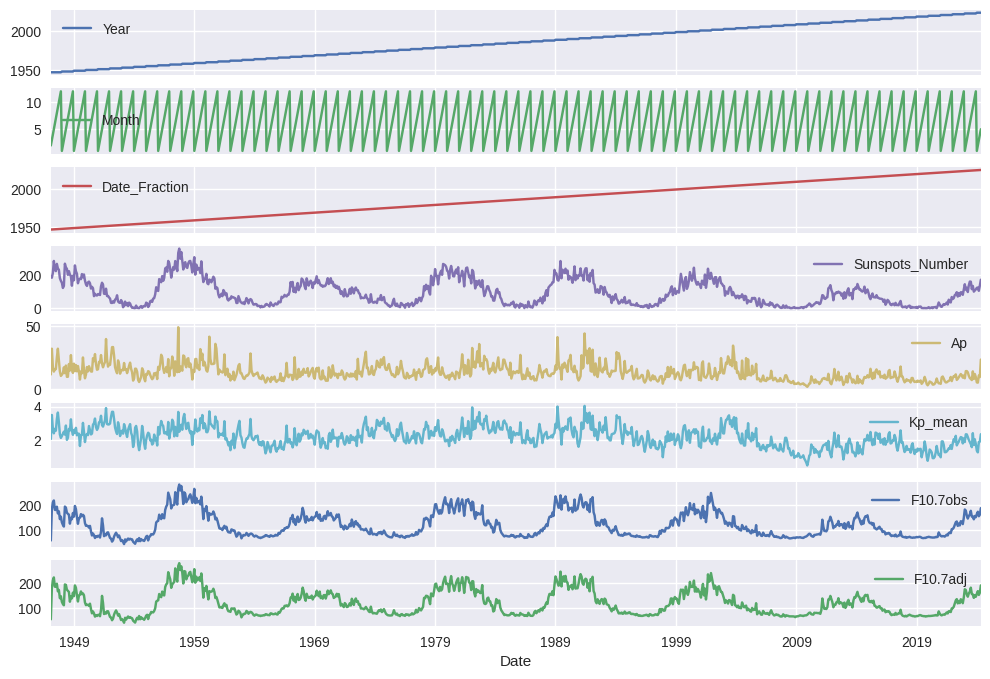

In [ ]:
filtered_data.plot(subplots=True, figsize=(12, 8))
plt.show()

            Year  Month  Date_Fraction  Sunspots_Number         Ap   Kp_mean  \
Date                                                                           
1947-02-01  1947      2       1947.123            188.9  11.750000  2.046116   
1947-03-01  1947      3       1947.204            183.8  32.225806  3.498661   
1947-04-01  1947      4       1947.288            212.1  17.700000  2.652779   
1947-05-01  1947      5       1947.371            285.0  14.032258  2.389766   
1947-06-01  1947      6       1947.455            232.1  16.000000  2.662496   

              F10.7obs    F10.7adj  
Date                                
1947-02-01   57.214286   55.975000  
1947-03-01  182.267742  180.500000  
1947-04-01  211.120000  212.470000  
1947-05-01  218.887097  223.851613  
1947-06-01  181.086667  186.873333  


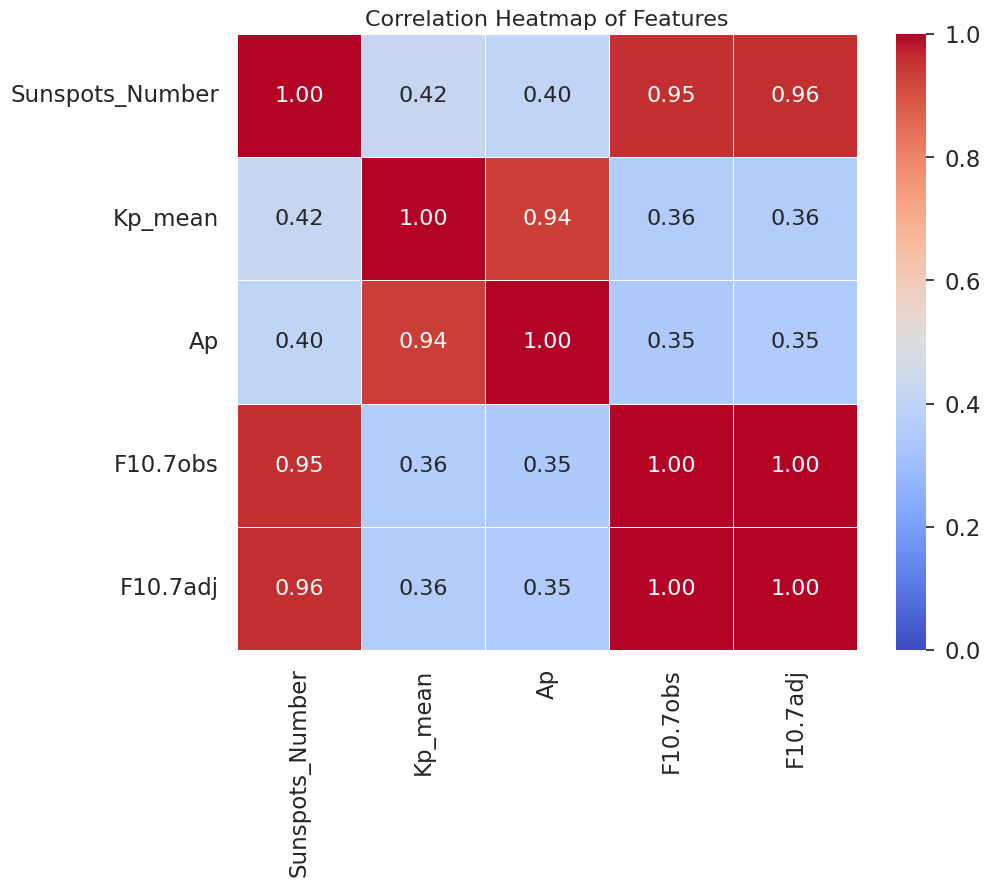

<Figure size 1600x900 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Print to verify the DataFrame structure (optional)
print(filtered_data.head())

# Ensure to select only the columns you want to include in the heatmap
features_of_interest = ['Sunspots_Number','Kp_mean', 'Ap', 'F10.7obs', 'F10.7adj']
filtered_data = filtered_data[features_of_interest]
corr = filtered_data[features_of_interest].corr()

# Set font scale for seaborn
sns.set(font_scale=1.5)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=0, vmax=1, annot_kws={"size": 16})
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.show()

# Optionally save the heatmap
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')


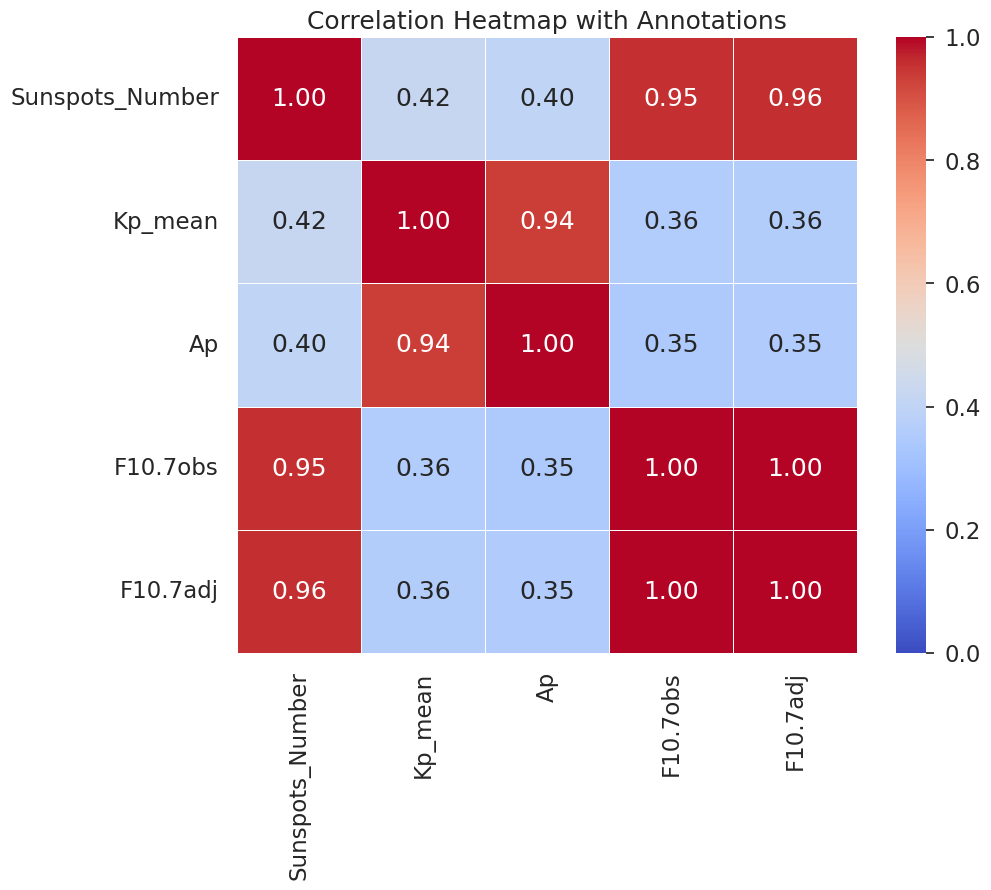

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a more detailed heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=0, vmax=1)
plt.title('Correlation Heatmap with Annotations')
plt.show()


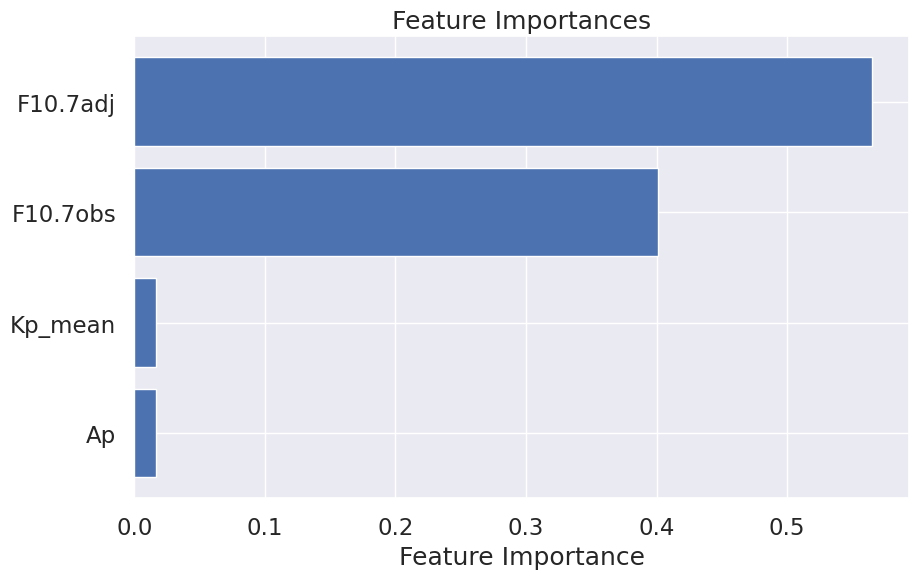

In [ ]:
import matplotlib.pyplot as plt

# Example: Feature importances from a RandomForest model
from sklearn.ensemble import RandomForestRegressor

# Fit the model
model = RandomForestRegressor()
model.fit(filtered_data[['Ap', 'Kp_mean', 'F10.7obs', 'F10.7adj']], filtered_data['Sunspots_Number'])

# Plot feature importances
importances = model.feature_importances_
features = ['Ap', 'Kp_mean', 'F10.7obs', 'F10.7adj']
plt.figure(figsize=(10, 6))
plt.barh(features, importances, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()


#Models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assume filtered_data is already defined and preprocessed as per your needs

# Resample data to quarterly frequency
filtered_data = filtered_data.resample('Q').mean()  # Adjust as needed, e.g., 'Q' for quarterly

# Perform seasonal decomposition if needed
result = seasonal_decompose(filtered_data['Sunspots_Number'], model='additive', period=4)  # Assuming quarterly periodicity
filtered_data['Seasonal'] = result.seasonal

# Split data into train and test sets (considering last 20% as test)
train_size = int(len(filtered_data) * 0.8)
train, test = filtered_data.iloc[:train_size], filtered_data.iloc[train_size:]

# Define lagged features if needed
lags = [1, 4]  # Example: lagged values for 1 quarter and 1 year (adjust as needed)

for lag in lags:
    train.loc[:, f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
    test.loc[:, f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)

# Drop rows with NaN values after creating lagged features
train.dropna(inplace=True)
test.dropna(inplace=True)

# Define evaluation metrics function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    return preds, mae, mse, rmse

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

### Baseline Model (Lagged Features Only) ###
baseline_results = {}

# Function to evaluate models and return metrics
def evaluate_models(train, test, model, params):
    results = {}
    maes, mses, rmses = [], [], []

    for train_index, test_index in tscv.split(train):
        train_cv, test_cv = train.iloc[train_index], train.iloc[test_index]
        X_train_cv = train_cv.drop(columns=['Sunspots_Number'])
        y_train_cv = train_cv['Sunspots_Number']
        X_test_cv = test_cv.drop(columns=['Sunspots_Number'])
        y_test_cv = test_cv['Sunspots_Number']

        model_instance = model(**params)  # Instantiate model here
        preds, mae, mse, rmse = evaluate_model(model_instance, X_train_cv, y_train_cv, X_test_cv, y_test_cv)
        maes.append(mae)
        mses.append(mse)
        rmses.append(rmse)

    results = {
        'MAE': np.mean(maes),
        'MSE': np.mean(mses),
        'RMSE': np.mean(rmses)
    }

    # Fit the final model on entire training data
    final_model = model(**params)
    final_model.fit(train.drop(columns=['Sunspots_Number']), train['Sunspots_Number'])
    test_preds = final_model.predict(test.drop(columns=['Sunspots_Number']))

    # Compute test set metrics
    test_mae = mean_absolute_error(test['Sunspots_Number'], test_preds)
    test_mse = mean_squared_error(test['Sunspots_Number'], test_preds)
    test_rmse = np.sqrt(test_mse)

    return results, test_preds, test_mae, test_mse, test_rmse

# Evaluate models with baseline feature set (only lagged Sunspots_Number values)
baseline_metrics = {}

# Define models and their parameters
lgb_params = {
    'num_leaves': 50,
    'max_depth': 10,
    'learning_rate': 0.05,
    'n_estimators': 500,
    'min_child_samples': 20
}

rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42
}

svr_params = {
    'kernel': 'rbf',
    'C': 100,
    'epsilon': 0.1
}

# Ensure models are directly accessible
models = {
    'LightGBM': lgb.LGBMRegressor,
    'RandomForest': RandomForestRegressor,
    'SVR': SVR
}

for model_name, params in [('LightGBM', lgb_params), ('RandomForest', rf_params), ('SVR', svr_params)]:
    preds, mae, mse, rmse = evaluate_models(train, test, model=models[model_name], params=params)
    baseline_results[model_name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

# Print and compare metrics for baseline models
print("Baseline Model (Lagged Features Only) Metrics:")
for model_name, metrics in baseline_metrics.items():
    print(f"{model_name}: MAE={metrics['MAE']}, MSE={metrics['MSE']}, RMSE={metrics['RMSE']}")

### Enhanced Model (Lagged + Extra Features) ###
# Add F10.7obs and Ap to the datasets
train_enhanced = train.copy()
test_enhanced = test.copy()

# Add F10.7obs and Ap to the enhanced datasets
train_enhanced['F10.7obs'] = filtered_data['F10.7obs']
train_enhanced['Ap'] = filtered_data['Ap']
test_enhanced['F10.7obs'] = filtered_data['F10.7obs']
test_enhanced['Ap'] = filtered_data['Ap']

# Add lagged features for enhanced datasets
for lag in lags:
    train_enhanced.loc[:, f'Sunspots_Number_Lag_{lag}'] = train_enhanced['Sunspots_Number'].shift(lag)
    test_enhanced.loc[:, f'Sunspots_Number_Lag_{lag}'] = test_enhanced['Sunspots_Number'].shift(lag)

# Drop rows with NaN values after adding features and creating lagged features
train_enhanced.dropna(inplace=True)
test_enhanced.dropna(inplace=True)

# Evaluate models with enhanced feature set (lagged Sunspots_Number values + F10.7obs + Ap)
enhanced_metrics = {}

for model_name, params in [('LightGBM', lgb_params), ('RandomForest', rf_params), ('SVR', svr_params)]:
    _, _, enhanced_metrics[model_name] = evaluate_models(train_enhanced, test_enhanced, model=models[model_name], params=params)

# Print and compare metrics for enhanced models
print("\nEnhanced Model (Lagged + Extra Features) Metrics:")
for model_name, metrics in enhanced_metrics.items():
    print(f"{model_name}: MAE={metrics['MAE']}, MSE={metrics['MSE']}, RMSE={metrics['RMSE']}")


<ipython-input-37-356ea99594fb>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
<ipython-input-37-356ea99594fb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)
<ipython-input-37-356ea99594fb>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 9
[LightGBM] [Info] Start training from score 132.535606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

ValueError: too many values to unpack (expected 4)

##Comparing features

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import SimpleImputer


# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define evaluation metrics function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    return preds, mae, mse, rmse

# Function to evaluate models and return metrics
def evaluate_models(train, test, model, params):
    results = {}
    maes, mses, rmses = [], [], []

    # Impute NaN values with mean
    imputer = SimpleImputer(strategy='mean')
    train_imputed = pd.DataFrame(imputer.fit_transform(train), columns=train.columns)
    test_imputed = pd.DataFrame(imputer.transform(test), columns=test.columns)

    for train_index, test_index in tscv.split(train):
        train_cv, test_cv = train_imputed.iloc[train_index], train_imputed.iloc[test_index]
        X_train_cv = train_cv.drop(columns=['Sunspots_Number'])
        y_train_cv = train_cv['Sunspots_Number']
        X_test_cv = test_cv.drop(columns=['Sunspots_Number'])
        y_test_cv = test_cv['Sunspots_Number']

        model_instance = model(**params)
        preds, mae, mse, rmse = evaluate_model(model_instance, X_train_cv, y_train_cv, X_test_cv, y_test_cv)
        maes.append(mae)
        mses.append(mse)
        rmses.append(rmse)

    results = {
        'MAE': np.mean(maes),
        'MSE': np.mean(mses),
        'RMSE': np.mean(rmses)
    }

    # Fit the final model on entire training data
    final_model = model(**params)
    final_model.fit(train_imputed.drop(columns=['Sunspots_Number']), train_imputed['Sunspots_Number'])
    test_preds = final_model.predict(test_imputed.drop(columns=['Sunspots_Number']))

    # Compute test set metrics
    test_mae = mean_absolute_error(test_imputed['Sunspots_Number'], test_preds)
    test_mse = mean_squared_error(test_imputed['Sunspots_Number'], test_preds)
    test_rmse = np.sqrt(test_mse)

    return results, test_preds, test_mae, test_mse, test_rmse

# Function to create lagged features
def create_lagged_features(df, lags):
    for lag in lags:
        df[f'Sunspots_Number_Lag_{lag}'] = df['Sunspots_Number'].shift(lag)
    return df.dropna()

# Function to add extra features (F10.7obs and Ap)
def add_extra_features(df, extra_features):
    for feature in extra_features:
        df[feature] = merged_data[feature]  # Assuming merged_data contains F10.7obs and Ap
    return df

# Resample data to quarterly frequency
df = df.resample('Q').mean()

# Perform seasonal decomposition if needed
result = seasonal_decompose(df['Sunspots_Number'], model='additive', period=4)
df['Seasonal'] = result.seasonal

# Define lagged features - Baseline: Only lagged Sunspots_Number values
lags = [1, 4]  # Example: lagged values for 1 quarter and 1 year (adjust as needed)
df_lagged_only = create_lagged_features(df.copy(), lags)

# Define additional features (F10.7obs and Ap)
extra_features = ['F10.7obs', 'Ap']
df_enhanced = add_extra_features(df.copy(), extra_features)
df_enhanced_lagged = create_lagged_features(df_enhanced.copy(), lags)

# Split data into train and test sets (considering last 20% as test)
train_size = int(len(df) * 0.8)
train_lagged_only, test_lagged_only = df_lagged_only.iloc[:train_size], df_lagged_only.iloc[train_size:]
train_enhanced, test_enhanced = df_enhanced_lagged.iloc[:train_size], df_enhanced_lagged.iloc[train_size:]

# Define models and their parameters
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42
}

# Evaluate models with baseline feature set (only lagged Sunspots_Number values)
baseline_results, baseline_preds, baseline_mae, baseline_mse, baseline_rmse = evaluate_models(train_lagged_only, test_lagged_only, RandomForestRegressor, rf_params)

# Evaluate models with enhanced feature set (lagged Sunspots_Number values + F10.7obs + Ap)
enhanced_results, enhanced_preds, enhanced_mae, enhanced_mse, enhanced_rmse = evaluate_models(train_enhanced, test_enhanced, RandomForestRegressor, rf_params)

# Plotting the predictions for baseline
plt.figure(figsize=(15, 7))
plt.plot(test_lagged_only.index, test_lagged_only['Sunspots_Number'], label='Actual')
plt.plot(test_lagged_only.index, baseline_preds, label='Baseline Prediction (Lagged Only)')
plt.legend()
plt.title('Baseline Test Set Predictions (Lagged Only)')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Plotting the predictions for enhanced features
plt.figure(figsize=(15, 7))
plt.plot(test_enhanced.index, test_enhanced['Sunspots_Number'], label='Actual')
plt.plot(test_enhanced.index, enhanced_preds, label='Enhanced Prediction (Lagged + F10.7obs + Ap)')
plt.legend()
plt.title('Enhanced Feature Test Set Predictions (Lagged + F10.7obs + Ap)')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results for comparison
print("\nComparison of Models:")
print("Baseline Model (Only Lagged Sunspots_Number) Metrics:")
print(f"MAE={baseline_mae}, MSE={baseline_mse}, RMSE={baseline_rmse}")
print("\nEnhanced Feature Model (Lagged Sunspots_Number + F10.7obs + Ap) Metrics:")
print(f"MAE={enhanced_mae}, MSE={enhanced_mse}, RMSE={enhanced_rmse}")


ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required by SimpleImputer.

##Comparing for only one

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming filtered_data is already defined as your DataFrame

# Create lagged features
filtered_data['Sunspots_Number_Lag_1'] = filtered_data['Sunspots_Number'].shift(1)
filtered_data['Sunspots_Number_Lag_4'] = filtered_data['Sunspots_Number'].shift(4)

# Drop rows with NaN values after creating lagged features
filtered_data.dropna(inplace=True)

# Define features and target
lagged_features = ['Sunspots_Number_Lag_1', 'Sunspots_Number_Lag_4']
target = 'Sunspots_Number'

# Define cross-validation strategy (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Function to evaluate Random Forest model with time series cross-validation
def evaluate_rf_cv(X, y, cv):
    mae_scores = []
    rmse_scores = []
    preds = []

    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        preds.extend(y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        mae_scores.append(mae)
        rmse_scores.append(rmse)

    return np.array(preds), np.mean(mae_scores), np.mean(rmse_scores)

# Evaluate Random Forest model with lagged features only (time series cross-validation)
X_lagged = filtered_data[lagged_features]
y_lagged = filtered_data[target]
preds_lagged_cv, mae_lagged_cv, rmse_lagged_cv = evaluate_rf_cv(X_lagged, y_lagged, cv=tscv)

# Print evaluation metrics
print("Random Forest Model Evaluation with Lagged Features Only (Time Series Cross-Validation):")
print(f"MAE: {mae_lagged_cv}")
print(f"RMSE: {rmse_lagged_cv}")


<ipython-input-17-9062834a34f1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Sunspots_Number_Lag_1'] = filtered_data['Sunspots_Number'].shift(1)
<ipython-input-17-9062834a34f1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Sunspots_Number_Lag_4'] = filtered_data['Sunspots_Number'].shift(4)
<ipython-input-17-9062834a34f1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

Random Forest Model Evaluation with Lagged Features Only (Time Series Cross-Validation):
MAE: 19.914950649350654
RMSE: 26.914212731878962


In [ ]:
# Define features including lagged values, solar indices, and characteristics
all_features = lagged_features + ['Ap', 'F10.7obs']

# Evaluate Random Forest model with all features (cross-validation)
X_all = filtered_data[all_features]
preds_all_cv, mae_all_cv, rmse_all_cv = evaluate_rf_cv(X_all, y_lagged, cv=tscv)

# Print evaluation metrics
print("\nRandom Forest Model Evaluation with Lagged Values, Solar Indices, and Characteristics (Cross-Validation):")
print(f"MAE: {mae_all_cv}")
print(f"RMSE: {rmse_all_cv}")



Random Forest Model Evaluation with Lagged Values, Solar Indices, and Characteristics (Cross-Validation):
MAE: 16.03074935064935
RMSE: 21.490863686234444


In [ ]:
# Define features including lagged values, solar indices, and characteristics
all_features = lagged_features + ['F10.7obs', 'Kp_mean']

# Evaluate Random Forest model with all features (cross-validation)
X_all = filtered_data[all_features]
preds_all_cv, mae_all_cv, rmse_all_cv = evaluate_rf_cv(X_all, y_lagged, cv=tscv)

# Print evaluation metrics
print("\nRandom Forest Model Evaluation with Lagged Values, Solar Indices, and Characteristics (Cross-Validation):")
print(f"MAE: {mae_all_cv}")
print(f"RMSE: {rmse_all_cv}")



Random Forest Model Evaluation with Lagged Values, Solar Indices, and Characteristics (Cross-Validation):
MAE: 16.08007922077922
RMSE: 21.55789628814403


##Possible correct comparison

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define feature sets
lagged_features = ['Sunspots_Number_Lag_1', 'Sunspots_Number_Lag_4']
full_features = lagged_features + ['Ap', 'Kp_mean', 'F10.7obs']

# Step 1: Split Data into Train and Test
train_size = int(len(filtered_data) * 0.8)  # 80% train, 20% test
train_data = filtered_data.iloc[:train_size]
test_data = filtered_data.iloc[train_size:]

# Step 2: Time Series Cross-Validation on Training Set for Lagged Features
tscv = TimeSeriesSplit(n_splits=5)
for train_index, val_index in tscv.split(train_data):
    train_fold = train_data.iloc[train_index]
    val_fold = train_data.iloc[val_index]

    # Feature selection for lagged features
    X_train = train_fold[lagged_features]
    y_train = train_fold['Sunspots_Number']
    X_val = val_fold[lagged_features]
    y_val = val_fold['Sunspots_Number']

    # Model training (Random Forest example)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predictions on validation fold
    preds_val = rf_model.predict(X_val)

    # Evaluation metrics on validation fold
    mae_val = mean_absolute_error(y_val, preds_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))

    print(f"Lagged Features - Validation MAE: {mae_val:.2f}, Validation RMSE: {rmse_val:.2f}")

# Train final model on entire training set with lagged features
X_train_lagged = train_data[lagged_features]
y_train_lagged = train_data['Sunspots_Number']
rf_model_lagged = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_lagged.fit(X_train_lagged, y_train_lagged)

# Evaluate on unseen test set with lagged features
X_test_lagged = test_data[lagged_features]
y_test_lagged = test_data['Sunspots_Number']
preds_test_lagged = rf_model_lagged.predict(X_test_lagged)

mae_test_lagged = mean_absolute_error(y_test_lagged, preds_test_lagged)
rmse_test_lagged = np.sqrt(mean_squared_error(y_test_lagged, preds_test_lagged))

print(f"Lagged Features - Test MAE: {mae_test_lagged:.2f}, Test RMSE: {rmse_test_lagged:.2f}")

# Step 3: Time Series Cross-Validation on Training Set for Full Features
for train_index, val_index in tscv.split(train_data):
    train_fold = train_data.iloc[train_index]
    val_fold = train_data.iloc[val_index]

    # Feature selection for full features
    X_train = train_fold[full_features]
    y_train = train_fold['Sunspots_Number']
    X_val = val_fold[full_features]
    y_val = val_fold['Sunspots_Number']

    # Model training (Random Forest example)
    rf_model_full = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_full.fit(X_train, y_train)

    # Predictions on validation fold
    preds_val = rf_model_full.predict(X_val)

    # Evaluation metrics on validation fold
    mae_val = mean_absolute_error(y_val, preds_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))

    print(f"Full Features - Validation MAE: {mae_val:.2f}, Validation RMSE: {rmse_val:.2f}")

# Train final model on entire training set with full features
X_train_full = train_data[full_features]
y_train_full = train_data['Sunspots_Number']
rf_model_full = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_full.fit(X_train_full, y_train_full)

# Evaluate on unseen test set with full features
X_test_full = test_data[full_features]
y_test_full = test_data['Sunspots_Number']
preds_test_full = rf_model_full.predict(X_test_full)

mae_test_full = mean_absolute_error(y_test_full, preds_test_full)
rmse_test_full = np.sqrt(mean_squared_error(y_test_full, preds_test_full))

print(f"Full Features - Test MAE: {mae_test_full:.2f}, Test RMSE: {rmse_test_full:.2f}")


Lagged Features - Validation MAE: 20.74, Validation RMSE: 29.44
Lagged Features - Validation MAE: 18.17, Validation RMSE: 23.39
Lagged Features - Validation MAE: 26.27, Validation RMSE: 33.70
Lagged Features - Validation MAE: 22.25, Validation RMSE: 30.78
Lagged Features - Validation MAE: 21.55, Validation RMSE: 28.45
Lagged Features - Test MAE: 15.75, Test RMSE: 21.81
Full Features - Validation MAE: 20.03, Validation RMSE: 24.97
Full Features - Validation MAE: 12.78, Validation RMSE: 16.50
Full Features - Validation MAE: 16.20, Validation RMSE: 21.92
Full Features - Validation MAE: 15.26, Validation RMSE: 21.30
Full Features - Validation MAE: 17.47, Validation RMSE: 23.49
Full Features - Test MAE: 12.28, Test RMSE: 17.80


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.metrics import r2_score

Sunspots_Number_Lag_1 =

# Define feature sets
lagged_features = ['Sunspots_Number_Lag_1', 'Sunspots_Number_Lag_4']
full_features = lagged_features + ['Ap', 'F10.7obs']

# Step 1: Split Data into Train and Test
train_size = int(len(filtered_data) * 0.9)  # 80% train, 20% test
train_data = filtered_data.iloc[:train_size]
test_data = filtered_data.iloc[train_size:]

# Initialize lists to store validation metrics across folds
mae_lagged_cv = []
rmse_lagged_cv = []
mae_full_cv = []
rmse_full_cv = []

# Step 2: Time Series Cross-Validation on Training Set for Lagged Features
tscv = TimeSeriesSplit(n_splits=5)
for train_index, val_index in tscv.split(train_data):
    train_fold = train_data.iloc[train_index]
    val_fold = train_data.iloc[val_index]

    # Feature selection for lagged features
    X_train = train_fold[lagged_features]
    y_train = train_fold['Sunspots_Number']
    X_val = val_fold[lagged_features]
    y_val = val_fold['Sunspots_Number']

    # Model training (Random Forest example)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predictions on validation fold
    preds_val = rf_model.predict(X_val)

    # Evaluation metrics on validation fold
    mae_val = mean_absolute_error(y_val, preds_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))

    # Store metrics for this fold
    mae_lagged_cv.append(mae_val)
    rmse_lagged_cv.append(rmse_val)

# Compute mean validation metrics for lagged features
mean_mae_lagged_cv = np.mean(mae_lagged_cv)
mean_rmse_lagged_cv = np.mean(rmse_lagged_cv)

print(f"Lagged Features - Mean Validation MAE: {mean_mae_lagged_cv:.2f}, Mean Validation RMSE: {mean_rmse_lagged_cv:.2f}")

# Train final model on entire training set with lagged features
X_train_lagged = train_data[lagged_features]
y_train_lagged = train_data['Sunspots_Number']
rf_model_lagged = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_lagged.fit(X_train_lagged, y_train_lagged)

# Evaluate on unseen test set with lagged features
X_test_lagged = test_data[lagged_features]
y_test_lagged = test_data['Sunspots_Number']
preds_test_lagged = rf_model_lagged.predict(X_test_lagged)

mae_test_lagged = mean_absolute_error(y_test_lagged, preds_test_lagged)
rmse_test_lagged = np.sqrt(mean_squared_error(y_test_lagged, preds_test_lagged))

print(f"Lagged Features - Test MAE: {mae_test_lagged:.2f}, Test RMSE: {rmse_test_lagged:.2f}")

# Step 3: Time Series Cross-Validation on Training Set for Full Features
for train_index, val_index in tscv.split(train_data):
    train_fold = train_data.iloc[train_index]
    val_fold = train_data.iloc[val_index]

    # Feature selection for full features
    X_train = train_fold[full_features]
    y_train = train_fold['Sunspots_Number']
    X_val = val_fold[full_features]
    y_val = val_fold['Sunspots_Number']

    # Model training (Random Forest example)
    rf_model_full = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_full.fit(X_train, y_train)

    # Predictions on validation fold
    preds_val = rf_model_full.predict(X_val)

    # Evaluation metrics on validation fold
    mae_val = mean_absolute_error(y_val, preds_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))

    # Store metrics for this fold
    mae_full_cv.append(mae_val)
    rmse_full_cv.append(rmse_val)

# Compute mean validation metrics for full features
mean_mae_full_cv = np.mean(mae_full_cv)
mean_rmse_full_cv = np.mean(rmse_full_cv)


print(f"Full Features - Mean Validation MAE: {mean_mae_full_cv:.2f}, Mean Validation RMSE: {mean_rmse_full_cv:.2f}")

# Train final model on entire training set with full features
X_train_full = train_data[full_features]
y_train_full = train_data['Sunspots_Number']
rf_model_full = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_full.fit(X_train_full, y_train_full)

# Evaluate on unseen test set with full features
X_test_full = test_data[full_features]
y_test_full = test_data['Sunspots_Number']
preds_test_full = rf_model_full.predict(X_test_full)

mae_test_full = mean_absolute_error(y_test_full, preds_test_full)
rmse_test_full = np.sqrt(mean_squared_error(y_test_full, preds_test_full))
r2_test_full = r2_score(y_test_full, preds_test_full)

print(f"Full Features - Test MAE: {mae_test_full:.2f}, Test RMSE: {rmse_test_full:.4f}")
print(f"Full Features - Test MAE: {mae_test_full:.2f}, Test RMSE: {rmse_test_full:.4f}, Test R^2: {r2_test_full:.4f}")


Lagged Features - Mean Validation MAE: 20.68, Mean Validation RMSE: 27.41
Lagged Features - Test MAE: 13.04, Test RMSE: 18.82
Full Features - Mean Validation MAE: 16.19, Mean Validation RMSE: 21.72
Full Features - Test MAE: 9.83, Test RMSE: 15.0827
Full Features - Test MAE: 9.83, Test RMSE: 15.0827, Test R^2: 0.9011


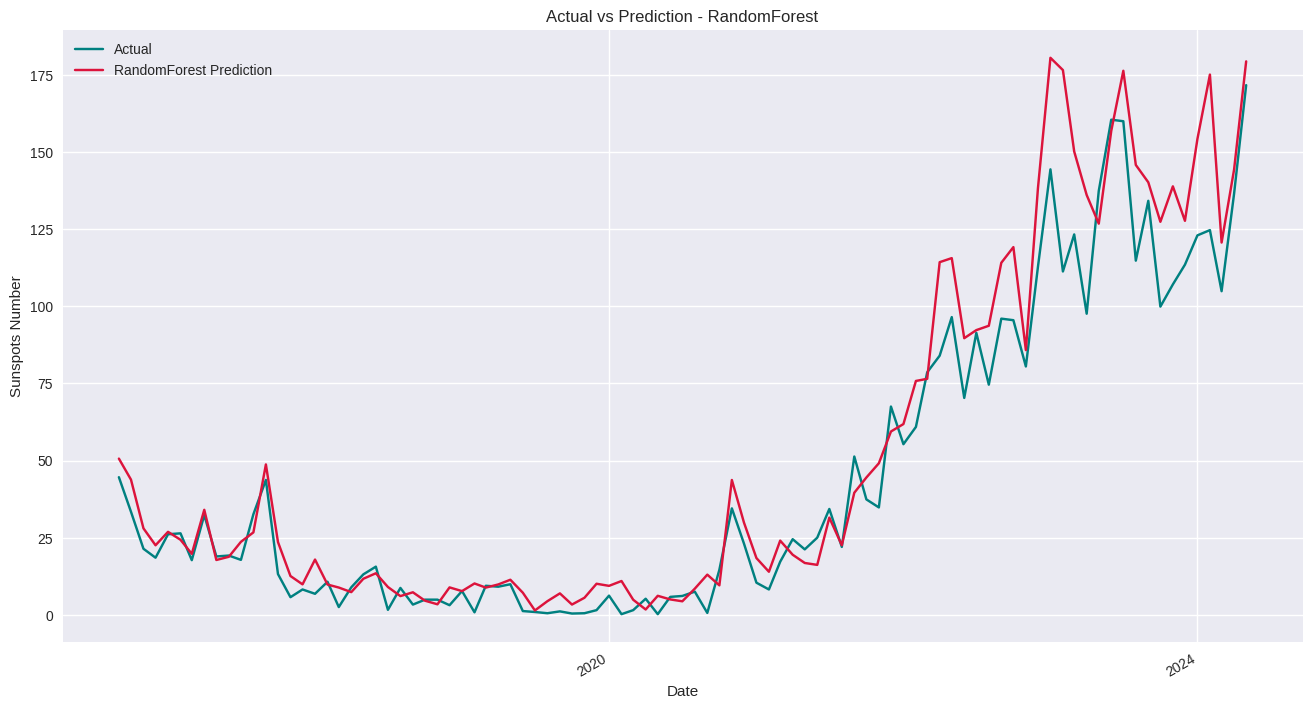

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming you've completed the earlier steps and have `preds_test_full`, `y_test_full`, and `test_data`

# Create DataFrame for plotting
test_results = pd.DataFrame({
    'Date': test_data.index,  # Ensure you have a DateTime index or column
    'Actual': y_test_full,
    'RandomForest_Predicted': preds_test_full
}).set_index('Date')

# Plotting test set predictions with RandomForest
plt.figure(figsize=(16, 9))
plt.plot(test_results.index, test_results['Actual'], label='Actual', color='teal')
plt.plot(test_results.index, test_results['RandomForest_Predicted'], label='RandomForest Prediction', color='crimson')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.title('Actual vs Prediction - RandomForest')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.grid(True)
plt.show()


###All machine learning with features

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR

# Define feature sets
lagged_features = ['Sunspots_Number_Lag_1', 'Sunspots_Number_Lag_2', 'Sunspots_Number_Lag_3', 'lagged']
full_features = lagged_features + ['Ap', 'F10.7obs', 'F10.7adj', 'Kp_mean']

# Step 1: Split Data into Train and Test
train_size = int(len(filtered_data) * 0.9)  # 90% train, 10% test
train_data = filtered_data.iloc[:train_size]
test_data = filtered_data.iloc[train_size:]

# Initialize lists to store validation metrics across folds
mae_lagged_cv = []
rmse_lagged_cv = []
r2_lagged_cv = []
mae_full_cv = []
rmse_full_cv = []
r2_full_cv = []

# Step 2: Time Series Cross-Validation on Training Set for Lagged Features
tscv = TimeSeriesSplit(n_splits=5)
for train_index, val_index in tscv.split(train_data):
    train_fold = train_data.iloc[train_index]
    val_fold = train_data.iloc[val_index]

    # Feature selection for lagged features
    X_train = train_fold[lagged_features]
    y_train = train_fold['Sunspots_Number']
    X_val = val_fold[lagged_features]
    y_val = val_fold['Sunspots_Number']

    # Model training (Random Forest example)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predictions on validation fold
    preds_val = rf_model.predict(X_val)

    # Evaluation metrics on validation fold
    mae_val = mean_absolute_error(y_val, preds_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))
    r2_val = r2_score(y_val, preds_val)

    # Store metrics for this fold
    mae_lagged_cv.append(mae_val)
    rmse_lagged_cv.append(rmse_val)
    r2_lagged_cv.append(r2_val)

# Compute mean validation metrics for lagged features
mean_mae_lagged_cv = np.mean(mae_lagged_cv)
mean_rmse_lagged_cv = np.mean(rmse_lagged_cv)
mean_r2_lagged_cv = np.mean(r2_lagged_cv)

print(f"Lagged Features - Mean Validation MAE: {mean_mae_lagged_cv:.2f}, Mean Validation RMSE: {mean_rmse_lagged_cv:.2f}, Mean Validation R^2: {mean_r2_lagged_cv:.4f}")

# Train final model on entire training set with lagged features
X_train_lagged = train_data[lagged_features]
y_train_lagged = train_data['Sunspots_Number']
rf_model_lagged = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_lagged.fit(X_train_lagged, y_train_lagged)

# Evaluate on unseen test set with lagged features
X_test_lagged = test_data[lagged_features]
y_test_lagged = test_data['Sunspots_Number']
preds_test_lagged = rf_model_lagged.predict(X_test_lagged)

mae_test_lagged = mean_absolute_error(y_test_lagged, preds_test_lagged)
rmse_test_lagged = np.sqrt(mean_squared_error(y_test_lagged, preds_test_lagged))
r2_test_lagged = r2_score(y_test_lagged, preds_test_lagged)

print(f"Lagged Features - Test MAE: {mae_test_lagged:.2f}, Test RMSE: {rmse_test_lagged:.2f}, Test R^2: {r2_test_lagged:.4f}")

# Step 3: Time Series Cross-Validation on Training Set for Full Features
for train_index, val_index in tscv.split(train_data):
    train_fold = train_data.iloc[train_index]
    val_fold = train_data.iloc[val_index]

    # Feature selection for full features
    X_train = train_fold[full_features]
    y_train = train_fold['Sunspots_Number']
    X_val = val_fold[full_features]
    y_val = val_fold['Sunspots_Number']

    # Model training (Random Forest example)
    rf_model_full = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_full.fit(X_train, y_train)

    # Predictions on validation fold
    preds_val = rf_model_full.predict(X_val)

    # Evaluation metrics on validation fold
    mae_val = mean_absolute_error(y_val, preds_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))
    r2_val = r2_score(y_val, preds_val)

    # Store metrics for this fold
    mae_full_cv.append(mae_val)
    rmse_full_cv.append(rmse_val)
    r2_full_cv.append(r2_val)

# Compute mean validation metrics for full features
mean_mae_full_cv = np.mean(mae_full_cv)
mean_rmse_full_cv = np.mean(rmse_full_cv)
mean_r2_full_cv = np.mean(r2_full_cv)

print(f"Full Features - Mean Validation MAE: {mean_mae_full_cv:.2f}, Mean Validation RMSE: {mean_rmse_full_cv:.2f}, Mean Validation R^2: {mean_r2_full_cv:.4f}")

# Train final model on entire training set with full features
X_train_full = train_data[full_features]
y_train_full = train_data['Sunspots_Number']
rf_model_full = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_full.fit(X_train_full, y_train_full)

# Evaluate on unseen test set with full features
X_test_full = test_data[full_features]
y_test_full = test_data['Sunspots_Number']
preds_test_full = rf_model_full.predict(X_test_full)

mae_test_full = mean_absolute_error(y_test_full, preds_test_full)
rmse_test_full = np.sqrt(mean_squared_error(y_test_full, preds_test_full))
r2_test_full = r2_score(y_test_full, preds_test_full)

print(f"Full Features - Test MAE: {mae_test_full:.2f}, Test RMSE: {rmse_test_full:.4f}, Test R^2: {r2_test_full:.4f}")

# Initialize and train XGBoost model
xgb_model = xgb.XGBRegressor(
    gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5,
    n_estimators=500, subsample=0.6, random_state=42
)
xgb_model.fit(X_train_full, y_train_full)
preds_test_xgb = xgb_model.predict(X_test_full)

# Evaluate XGBoost model
mae_test_xgb = mean_absolute_error(y_test_full, preds_test_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_full, preds_test_xgb))
r2_test_xgb = r2_score(y_test_full, preds_test_xgb)

print(f"XGBoost - Test MAE: {mae_test_xgb:.2f}, Test RMSE: {rmse_test_xgb:.4f}, Test R^2: {r2_test_xgb:.4f}")

# Initialize and train LightGBM model
lgb_model = lgb.LGBMRegressor(
    boosting_type='gbdt', learning_rate=0.01, max_depth=3, min_child_samples=30,
    n_estimators=500, num_leaves=31, subsample=0.6, random_state=42
)
lgb_model.fit(X_train_full, y_train_full)
preds_test_lgb = lgb_model.predict(X_test_full)

# Evaluate LightGBM model
mae_test_lgb = mean_absolute_error(y_test_full, preds_test_lgb)
rmse_test_lgb = np.sqrt(mean_squared_error(y_test_full, preds_test_lgb))
r2_test_lgb = r2_score(y_test_full, preds_test_lgb)

print(f"LightGBM - Test MAE: {mae_test_lgb:.2f}, Test RMSE: {rmse_test_lgb:.4f}, Test R^2: {r2_test_lgb:.4f}")

# Initialize and train SVR model
# (Replace parameters with the ones you finalize later)
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_full, y_train_full)
preds_test_svr = svr_model.predict(X_test_full)

# Evaluate SVR model
mae_test_svr = mean_absolute_error(y_test_full, preds_test_svr)
rmse_test_svr = np.sqrt(mean_squared_error(y_test_full, preds_test_svr))
r2_test_svr = r2_score(y_test_full, preds_test_svr)

print(f"SVR - Test MAE: {mae_test_svr:.2f}, Test RMSE: {rmse_test_svr:.4f}, Test R^2: {r2_test_svr:.4f}")


KeyError: "None of [Index(['Sunspots_Number_Lag_1', 'Sunspots_Number_Lag_4'], dtype='object')] are in the [columns]"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR

# Assuming 'filtered_data' is your DataFrame
# Define feature sets
lagged_features = ['Sunspots_Number_Lag_1', 'Sunspots_Number_Lag_4']
full_features = lagged_features + ['Ap', 'F10.7obs']

# Split Data into Train and Test
train_size = int(len(filtered_data) * 0.9)  # 90% train, 10% test
train_data = filtered_data.iloc[:train_size]
test_data = filtered_data.iloc[train_size:]

# Initialize lists to store validation metrics across folds
metrics = {
    'RandomForest_Lagged': {'mae': [], 'rmse': [], 'r2': []},
    'RandomForest_Full': {'mae': [], 'rmse': [], 'r2': []},
    'XGBoost_Lagged': {'mae': [], 'rmse': [], 'r2': []},
    'XGBoost_Full': {'mae': [], 'rmse': [], 'r2': []},
    'LightGBM_Lagged': {'mae': [], 'rmse': [], 'r2': []},
    'LightGBM_Full': {'mae': [], 'rmse': [], 'r2': []},
    'SVR_Lagged': {'mae': [], 'rmse': [], 'r2': []},
    'SVR_Full': {'mae': [], 'rmse': [], 'r2': []}
}

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    model.fit(X_train, y_train)
    preds_val = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds_val))
    r2 = r2_score(y_val, preds_val)
    return mae, rmse, r2

# Train and Evaluate Models for Lagged Features
for train_index, val_index in tscv.split(train_data):
    train_fold = train_data.iloc[train_index]
    val_fold = train_data.iloc[val_index]

    X_train_lagged = train_fold[lagged_features]
    y_train_lagged = train_fold['Sunspots_Number']
    X_val_lagged = val_fold[lagged_features]
    y_val_lagged = val_fold['Sunspots_Number']

    # RandomForest with Lagged Features
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    mae, rmse, r2 = evaluate_model(rf_model, X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged, 'RandomForest_Lagged')
    metrics['RandomForest_Lagged']['mae'].append(mae)
    metrics['RandomForest_Lagged']['rmse'].append(rmse)
    metrics['RandomForest_Lagged']['r2'].append(r2)

    # XGBoost with Lagged Features
    xgb_model = xgb.XGBRegressor(
        gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5,
        n_estimators=500, subsample=0.6, random_state=42
    )
    mae, rmse, r2 = evaluate_model(xgb_model, X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged, 'XGBoost_Lagged')
    metrics['XGBoost_Lagged']['mae'].append(mae)
    metrics['XGBoost_Lagged']['rmse'].append(rmse)
    metrics['XGBoost_Lagged']['r2'].append(r2)

    # LightGBM with Lagged Features
    lgb_model = lgb.LGBMRegressor(
        boosting_type='gbdt', learning_rate=0.01, max_depth=3, min_child_samples=30,
        n_estimators=500, num_leaves=31, subsample=0.6, random_state=42
    )
    mae, rmse, r2 = evaluate_model(lgb_model, X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged, 'LightGBM_Lagged')
    metrics['LightGBM_Lagged']['mae'].append(mae)
    metrics['LightGBM_Lagged']['rmse'].append(rmse)
    metrics['LightGBM_Lagged']['r2'].append(r2)

    # SVR with Lagged Features
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    mae, rmse, r2 = evaluate_model(svr_model, X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged, 'SVR_Lagged')
    metrics['SVR_Lagged']['mae'].append(mae)
    metrics['SVR_Lagged']['rmse'].append(rmse)
    metrics['SVR_Lagged']['r2'].append(r2)

# Compute mean validation metrics for lagged features
mean_metrics_lagged = {model: {metric: np.mean(metrics[model][metric]) for metric in metrics[model]} for model in metrics if 'Lagged' in model}

print("Lagged Features - Mean Validation Metrics:")
for model, metric_values in mean_metrics_lagged.items():
    print(f"{model} - Mean Validation MAE: {metric_values['mae']:.2f}, Mean Validation RMSE: {metric_values['rmse']:.2f}, Mean Validation R^2: {metric_values['r2']:.4f}")

# Train final models on entire training set with lagged features
X_train_lagged = train_data[lagged_features]
y_train_lagged = train_data['Sunspots_Number']
X_test_lagged = test_data[lagged_features]
y_test_lagged = test_data['Sunspots_Number']

def final_evaluation(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    preds_test = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds_test))
    r2 = r2_score(y_test, preds_test)
    return mae, rmse, r2

# Evaluate models with lagged features on the test set
results_lagged = {}
for model_name in metrics:
    if 'Lagged' in model_name:
        model_class = {
            'RandomForest_Lagged': RandomForestRegressor(n_estimators=100, random_state=42),
            'XGBoost_Lagged': xgb.XGBRegressor(
                gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5,
                n_estimators=500, subsample=0.6, random_state=42
            ),
            'LightGBM_Lagged': lgb.LGBMRegressor(
                boosting_type='gbdt', learning_rate=0.01, max_depth=3, min_child_samples=30,
                n_estimators=500, num_leaves=31, subsample=0.6, random_state=42
            ),
            'SVR_Lagged': SVR(kernel='rbf', C=1.0, epsilon=0.1)
        }[model_name]
        mae, rmse, r2 = final_evaluation(model_class, X_train_lagged, y_train_lagged, X_test_lagged, y_test_lagged, model_name)
        results_lagged[model_name] = {'MAE': mae, 'RMSE': rmse, 'R^2': r2}

print("\nLagged Features - Test Metrics:")
for model, metric_values in results_lagged.items():
    print(f"{model} - Test MAE: {metric_values['MAE']:.2f}, Test RMSE: {metric_values['RMSE']:.4f}, Test R^2: {metric_values['R^2']:.4f}")

# Train and Evaluate Models for Full Features
for train_index, val_index in tscv.split(train_data):
    train_fold = train_data.iloc[train_index]
    val_fold = train_data.iloc[val_index]

    X_train_full = train_fold[full_features]
    y_train_full = train_fold['Sunspots_Number']
    X_val_full = val_fold[full_features]
    y_val_full = val_fold['Sunspots_Number']

    # RandomForest with Full Features
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    mae, rmse, r2 = evaluate_model(rf_model, X_train_full, y_train_full, X_val_full, y_val_full, 'RandomForest_Full')
    metrics['RandomForest_Full']['mae'].append(mae)
    metrics['RandomForest_Full']['rmse'].append(rmse)
    metrics['RandomForest_Full']['r2'].append(r2)

    # XGBoost with Full Features
    xgb_model = xgb.XGBRegressor(
        gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5,
        n_estimators=500, subsample=0.6, random_state=42
    )
    mae, rmse, r2 = evaluate_model(xgb_model, X_train_full, y_train_full, X_val_full, y_val_full, 'XGBoost_Full')
    metrics['XGBoost_Full']['mae'].append(mae)
    metrics['XGBoost_Full']['rmse'].append(rmse)
    metrics['XGBoost_Full']['r2'].append(r2)

    # LightGBM with Full Features
    lgb_model = lgb.LGBMRegressor(
        boosting_type='gbdt', learning_rate=0.01, max_depth=3, min_child_samples=30,
        n_estimators=500, num_leaves=31, subsample=0.6, random_state=42
    )
    mae, rmse, r2 = evaluate_model(lgb_model, X_train_full, y_train_full, X_val_full, y_val_full, 'LightGBM_Full')
    metrics['LightGBM_Full']['mae'].append(mae)
    metrics['LightGBM_Full']['rmse'].append(rmse)
    metrics['LightGBM_Full']['r2'].append(r2)

    # SVR with Full Features
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    mae, rmse, r2 = evaluate_model(svr_model, X_train_full, y_train_full, X_val_full, y_val_full, 'SVR_Full')
    metrics['SVR_Full']['mae'].append(mae)
    metrics['SVR_Full']['rmse'].append(rmse)
    metrics['SVR_Full']['r2'].append(r2)

# Compute mean validation metrics for full features
mean_metrics_full = {model: {metric: np.mean(metrics[model][metric]) for metric in metrics[model]} for model in metrics if 'Full' in model}

print("\nFull Features - Mean Validation Metrics:")
for model, metric_values in mean_metrics_full.items():
    print(f"{model} - Mean Validation MAE: {metric_values['mae']:.2f}, Mean Validation RMSE: {metric_values['rmse']:.2f}, Mean Validation R^2: {metric_values['r2']:.4f}")

# Evaluate models with full features on the test set
results_full = {}
for model_name in metrics:
    if 'Full' in model_name:
        model_class = {
            'RandomForest_Full': RandomForestRegressor(n_estimators=100, random_state=42),
            'XGBoost_Full': xgb.XGBRegressor(
                gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5,
                n_estimators=500, subsample=0.6, random_state=42
            ),
            'LightGBM_Full': lgb.LGBMRegressor(
                boosting_type='gbdt', learning_rate=0.01, max_depth=3, min_child_samples=30,
                n_estimators=500, num_leaves=31, subsample=0.6, random_state=42
            ),
            'SVR_Full': SVR(kernel='rbf', C=1.0, epsilon=0.1)
        }[model_name]
        mae, rmse, r2 = final_evaluation(model_class, X_train_full, y_train_full, X_test_full, y_test_full, model_name)
        results_full[model_name] = {'MAE': mae, 'RMSE': rmse, 'R^2': r2}

print("\nFull Features - Test Metrics:")
for model, metric_values in results_full.items():
    print(f"{model} - Test MAE: {metric_values['MAE']:.2f}, Test RMSE: {metric_values['RMSE']:.4f}, Test R^2: {metric_values['R^2']:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 141, number of used features: 2
[LightGBM] [Info] Start training from score 138.622695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
# Determine the best model based on RMSE
results = {**results_lagged, **results_full}
best_model = min(results, key=lambda model: results[model]['RMSE'])
print(f"\nBest Model: {best_model}")
print(f"{best_model} - Test MAE: {results[best_model]['MAE']:.2f}, Test RMSE: {results[best_model]['RMSE']:.4f}, Test R^2: {results[best_model]['R^2']:.4f}")

# Create DataFrame for plotting
test_results = pd.DataFrame({
    'Date': test_data.index,
    'Actual': y_test_full,
    # 'RandomForest_Predicted_Lagged': preds_test_rf_lagged,
    'XGBoost_Predicted_Lagged': preds_test_xgb_lagged,
    'LightGBM_Predicted_Lagged': preds_test_lgb_lagged,
    'SVR_Predicted_Lagged': preds_test_svr_lagged,
    'RandomForest_Predicted_Full': preds_test_rf_full,
    'XGBoost_Predicted_Full': preds_test_xgb_full,
    'LightGBM_Predicted_Full': preds_test_lgb_full,
    'SVR_Predicted_Full': preds_test_svr_full
}).set_index('Date')

# Plotting test set predictions for all models
plt.figure(figsize=(16, 9))
plt.plot(test_results.index, test_results['Actual'], label='Actual', color='teal')
plt.plot(test_results.index, test_results['RandomForest_Predicted_Lagged'], label='RandomForest Lagged', color='crimson')
plt.plot(test_results.index, test_results['XGBoost_Predicted_Lagged'], label='XGBoost Lagged', color='blue')
plt.plot(test_results.index, test_results['LightGBM_Predicted_Lagged'], label='LightGBM Lagged', color='orange')
plt.plot(test_results.index, test_results['SVR_Predicted_Lagged'], label='SVR Lagged', color='green')
plt.plot(test_results.index, test_results['RandomForest_Predicted_Full'], label='RandomForest Full', color='red', linestyle='--')
plt.plot(test_results.index, test_results['XGBoost_Predicted_Full'], label='XGBoost Full', color='cyan', linestyle='--')
plt.plot(test_results.index, test_results['LightGBM_Predicted_Full'], label='LightGBM Full', color='purple', linestyle='--')
plt.plot(test_results.index, test_results['SVR_Predicted_Full'], label='SVR Full', color='yellowgreen', linestyle='--')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.title('Actual vs Prediction - All Models (Lagged vs Full Features)')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.grid(True)
plt.show()


Best Model: LightGBM_Full
LightGBM_Full - Test MAE: 11.56, Test RMSE: 15.2522, Test R^2: 0.8988


NameError: name 'preds_test_xgb_lagged' is not defined

NEW COMPARISON WITH LAGGED

In [ ]:
# Create additional lagged features
for lag in range(1, 7):
    filtered_data[f'Sunspots_Number_Lag_{lag}'] = filtered_data['Sunspots_Number'].shift(lag)

# Update lagged features list to include all 6 lags
lagged_features = [f'Sunspots_Number_Lag_{lag}' for lag in range(1, 7)]
full_features = lagged_features + ['Ap', 'F10.7obs', 'Kp_mean', 'F10.7adj']

# Drop rows with NaN values due to lagged features
filtered_data.dropna(inplace=True)


In [ ]:
# Shift the target variable by one step for one-step-ahead predictions
filtered_data['Sunspots_Number_Target'] = filtered_data['Sunspots_Number'].shift(-1)

# Drop the last row as it will have NaN target value after shifting
filtered_data.dropna(inplace=True)


In [ ]:
# Split Data into Train and Test
train_size = int(len(filtered_data) * 0.9)  # 90% train, 10% test
train_data = filtered_data.iloc[:train_size]
test_data = filtered_data.iloc[train_size:]

# Update y_train and y_test to use the new target variable
y_train_lagged = train_data['Sunspots_Number_Target']
y_test_lagged = test_data['Sunspots_Number_Target']


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR

# Assuming 'filtered_data' is your DataFrame
# Add more lagged features
def add_lagged_features(df, lags):
    for lag in lags:
        df[f'Sunspots_Number_Lag_{lag}'] = df['Sunspots_Number'].shift(lag)
    return df

# Add lagged features
lagged_values = [1, 2, 3, 4, 5, 6]  # Add more lags here if needed
filtered_data = add_lagged_features(filtered_data, lagged_values)

# Set the target variable for one-step-ahead prediction
filtered_data['Sunspots_Number_Target'] = filtered_data['Sunspots_Number'].shift(-1)

# Drop rows with NaN values due to lagging and shifting
filtered_data = filtered_data.dropna()

# Define feature sets
lagged_features = [f'Sunspots_Number_Lag_{lag}' for lag in lagged_values]
full_features = lagged_features + ['F10.7obs', 'F10.7adj']

# Split Data into Train and Test
train_size = int(len(filtered_data) * 0.9)  # 90% train, 10% test
train_data = filtered_data.iloc[:train_size]
test_data = filtered_data.iloc[train_size:]

# Initialize lists to store validation metrics across folds
metrics = {
    'RandomForest_Lagged': {'mae': [], 'rmse': [], 'r2': []},
    'RandomForest_Full': {'mae': [], 'rmse': [], 'r2': []},
    'XGBoost_Lagged': {'mae': [], 'rmse': [], 'r2': []},
    'XGBoost_Full': {'mae': [], 'rmse': [], 'r2': []},
    'LightGBM_Lagged': {'mae': [], 'rmse': [], 'r2': []},
    'LightGBM_Full': {'mae': [], 'rmse': [], 'r2': []},
    'SVR_Lagged': {'mae': [], 'rmse': [], 'r2': []},
    'SVR_Full': {'mae': [], 'rmse': [], 'r2': []}
}

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    model.fit(X_train, y_train)
    preds_val = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds_val))
    r2 = r2_score(y_val, preds_val)
    return mae, rmse, r2

# Train and Evaluate Models for Lagged Features
for train_index, val_index in tscv.split(train_data):
    train_fold = train_data.iloc[train_index]
    val_fold = train_data.iloc[val_index]

    X_train_lagged = train_fold[lagged_features]
    y_train_lagged = train_fold['Sunspots_Number_Target']
    X_val_lagged = val_fold[lagged_features]
    y_val_lagged = val_fold['Sunspots_Number_Target']

    # RandomForest with Lagged Features
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    mae, rmse, r2 = evaluate_model(rf_model, X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged, 'RandomForest_Lagged')
    metrics['RandomForest_Lagged']['mae'].append(mae)
    metrics['RandomForest_Lagged']['rmse'].append(rmse)
    metrics['RandomForest_Lagged']['r2'].append(r2)

    # XGBoost with Lagged Features
    xgb_model = xgb.XGBRegressor(
        gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5,
        n_estimators=500, subsample=0.6, random_state=42
    )
    mae, rmse, r2 = evaluate_model(xgb_model, X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged, 'XGBoost_Lagged')
    metrics['XGBoost_Lagged']['mae'].append(mae)
    metrics['XGBoost_Lagged']['rmse'].append(rmse)
    metrics['XGBoost_Lagged']['r2'].append(r2)

    # LightGBM with Lagged Features
    lgb_model = lgb.LGBMRegressor(
        boosting_type='gbdt', learning_rate=0.01, max_depth=3, min_child_samples=30,
        n_estimators=500, num_leaves=31, subsample=0.6, random_state=42
    )
    mae, rmse, r2 = evaluate_model(lgb_model, X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged, 'LightGBM_Lagged')
    metrics['LightGBM_Lagged']['mae'].append(mae)
    metrics['LightGBM_Lagged']['rmse'].append(rmse)
    metrics['LightGBM_Lagged']['r2'].append(r2)

    # SVR with Lagged Features
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    mae, rmse, r2 = evaluate_model(svr_model, X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged, 'SVR_Lagged')
    metrics['SVR_Lagged']['mae'].append(mae)
    metrics['SVR_Lagged']['rmse'].append(rmse)
    metrics['SVR_Lagged']['r2'].append(r2)

# Compute mean validation metrics for lagged features
mean_metrics_lagged = {model: {metric: np.mean(metrics[model][metric]) for metric in metrics[model]} for model in metrics if 'Lagged' in model}

print("Lagged Features - Mean Validation Metrics:")
for model, metric_values in mean_metrics_lagged.items():
    print(f"{model} - Mean Validation MAE: {metric_values['mae']:.2f}, Mean Validation RMSE: {metric_values['rmse']:.2f}, Mean Validation R^2: {metric_values['r2']:.4f}")

# Define final evaluation function
def final_evaluation(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    preds_test = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds_test))
    r2 = r2_score(y_test, preds_test)
    return mae, rmse, r2

# Train final models on entire training set with lagged features
X_train_lagged = train_data[lagged_features]
y_train_lagged = train_data['Sunspots_Number_Target']
X_test_lagged = test_data[lagged_features]
y_test_lagged = test_data['Sunspots_Number_Target']

# Evaluate models with lagged features on the test set
results_lagged = {}
for model_name in metrics:
    if 'Lagged' in model_name:
        model_class = {
            'RandomForest_Lagged': RandomForestRegressor(n_estimators=100, random_state=42),
            'XGBoost_Lagged': xgb.XGBRegressor(
                gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5,
                n_estimators=500, subsample=0.6, random_state=42
            ),
            'LightGBM_Lagged': lgb.LGBMRegressor(
                boosting_type='gbdt', learning_rate=0.01, max_depth=3, min_child_samples=30,
                n_estimators=500, num_leaves=31, subsample=0.6, random_state=42
            ),
            'SVR_Lagged': SVR(kernel='rbf', C=1.0, epsilon=0.1)
        }[model_name]
        mae, rmse, r2 = final_evaluation(model_class, X_train_lagged, y_train_lagged, X_test_lagged, y_test_lagged, model_name)
        results_lagged[model_name] = {'MAE': mae, 'RMSE': rmse, 'R^2': r2}

print("\nLagged Features - Test Metrics:")
for model, metric_values in results_lagged.items():
    print(f"{model} - Test MAE: {metric_values['MAE']:.2f}, Test RMSE: {metric_values['RMSE']:.4f}, Test R^2: {metric_values['R^2']:.4f}")

# Train and Evaluate Models for Full Features
for train_index, val_index in tscv.split(train_data):
    train_fold = train_data.iloc[train_index]
    val_fold = train_data.iloc[val_index]

    X_train_full = train_fold[full_features]
    y_train_full = train_fold['Sunspots_Number_Target']
    X_val_full = val_fold[full_features]
    y_val_full = val_fold['Sunspots_Number_Target']

    # RandomForest with Full Features
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    mae, rmse, r2 = evaluate_model(rf_model, X_train_full, y_train_full, X_val_full, y_val_full, 'RandomForest_Full')
    metrics['RandomForest_Full']['mae'].append(mae)
    metrics['RandomForest_Full']['rmse'].append(rmse)
    metrics['RandomForest_Full']['r2'].append(r2)

    # XGBoost with Full Features
    xgb_model = xgb.XGBRegressor(
        gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5,
        n_estimators=500, subsample=0.6, random_state=42
    )
    mae, rmse, r2 = evaluate_model(xgb_model, X_train_full, y_train_full, X_val_full, y_val_full, 'XGBoost_Full')
    metrics['XGBoost_Full']['mae'].append(mae)
    metrics['XGBoost_Full']['rmse'].append(rmse)
    metrics['XGBoost_Full']['r2'].append(r2)

    # LightGBM with Full Features
    lgb_model = lgb.LGBMRegressor(
        boosting_type='gbdt', learning_rate=0.01, max_depth=3, min_child_samples=30,
        n_estimators=500, num_leaves=31, subsample=0.6, random_state=42
    )
    mae, rmse, r2 = evaluate_model(lgb_model, X_train_full, y_train_full, X_val_full, y_val_full, 'LightGBM_Full')
    metrics['LightGBM_Full']['mae'].append(mae)
    metrics['LightGBM_Full']['rmse'].append(rmse)
    metrics['LightGBM_Full']['r2'].append(r2)

    # SVR with Full Features
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    mae, rmse, r2 = evaluate_model(svr_model, X_train_full, y_train_full, X_val_full, y_val_full, 'SVR_Full')
    metrics['SVR_Full']['mae'].append(mae)
    metrics['SVR_Full']['rmse'].append(rmse)
    metrics['SVR_Full']['r2'].append(r2)

# Compute mean validation metrics for full features
mean_metrics_full = {model: {metric: np.mean(metrics[model][metric]) for metric in metrics[model]} for model in metrics if 'Full' in model}

print("\nFull Features - Mean Validation Metrics:")
for model, metric_values in mean_metrics_full.items():
    print(f"{model} - Mean Validation MAE: {metric_values['mae']:.2f}, Mean Validation RMSE: {metric_values['rmse']:.2f}, Mean Validation R^2: {metric_values['r2']:.4f}")

# Train final models on entire training set with full features
X_train_full = train_data[full_features]
y_train_full = train_data['Sunspots_Number_Target']
X_test_full = test_data[full_features]
y_test_full = test_data['Sunspots_Number_Target']

# Evaluate models with full features on the test set
results_full = {}
for model_name in metrics:
    if 'Full' in model_name:
        model_class = {
            'RandomForest_Full': RandomForestRegressor(n_estimators=100, random_state=42),
            'XGBoost_Full': xgb.XGBRegressor(
                gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5,
                n_estimators=500, subsample=0.6, random_state=42
            ),
            'LightGBM_Full': lgb.LGBMRegressor(
                boosting_type='gbdt', learning_rate=0.01, max_depth=3, min_child_samples=30,
                n_estimators=500, num_leaves=31, subsample=0.6, random_state=42
            ),
            'SVR_Full': SVR(kernel='rbf', C=1.0, epsilon=0.1)
        }[model_name]
        mae, rmse, r2 = final_evaluation(model_class, X_train_full, y_train_full, X_test_full, y_test_full, model_name)
        results_full[model_name] = {'MAE': mae, 'RMSE': rmse, 'R^2': r2}

print("\nFull Features - Test Metrics:")
for model, metric_values in results_full.items():
    print(f"{model} - Test MAE: {metric_values['MAE']:.2f}, Test RMSE: {metric_values['RMSE']:.4f}, Test R^2: {metric_values['R^2']:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 281
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 6
[LightGBM] [Info] Start training from score 136.397101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

###BIG4 with rolling mean

<ipython-input-136-61372eb3c216>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'Sunspots_Number_Lag_{lag}'] = df['Sunspots_Number'].shift(lag)
<ipython-input-136-61372eb3c216>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'Sunspots_Number_Lag_{lag}'] = df['Sunspots_Number'].shift(lag)
<ipython-input-136-61372eb3c216>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d


Best RandomForest_Lagged_RM Parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
RandomForest_Lagged_RM Test Set Metrics:
MAE=11.532834555826096, MSE=297.79462249020105, RMSE=17.256726876502423, R2=0.870511855520955


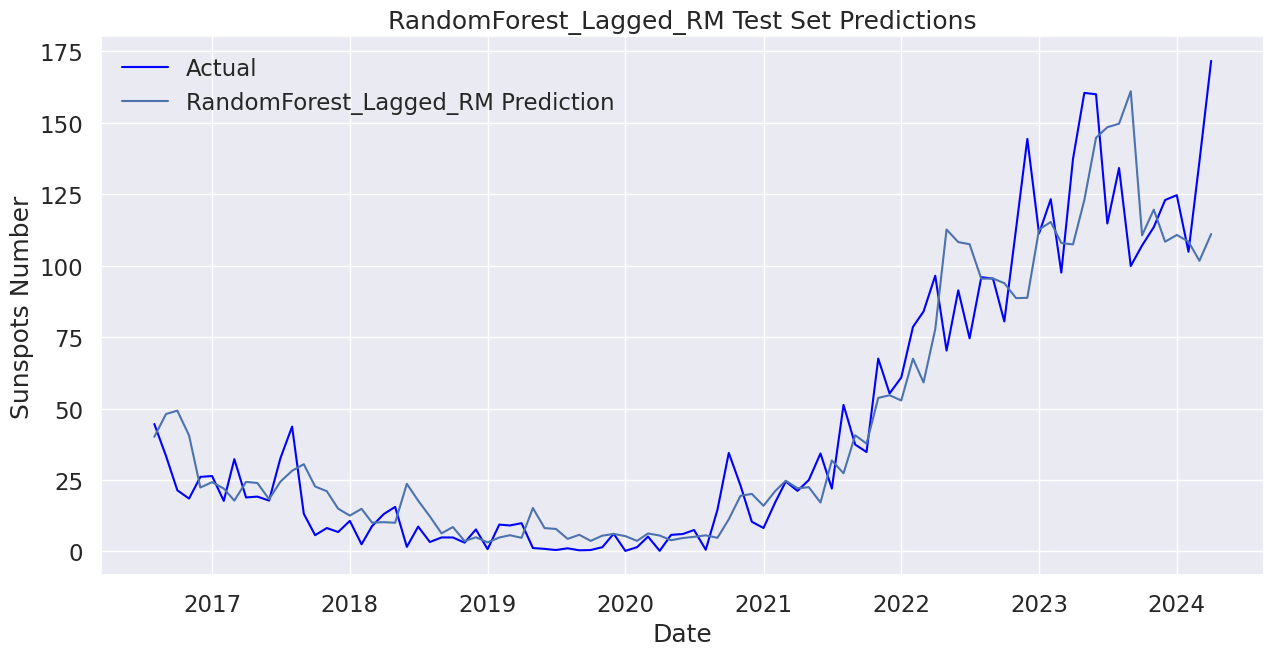


Best XGBoost_Lagged_RM Parameters:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
XGBoost_Lagged_RM Test Set Metrics:
MAE=11.779297608201224, MSE=267.0653908981515, RMSE=16.34213544486006, R2=0.883873652140544


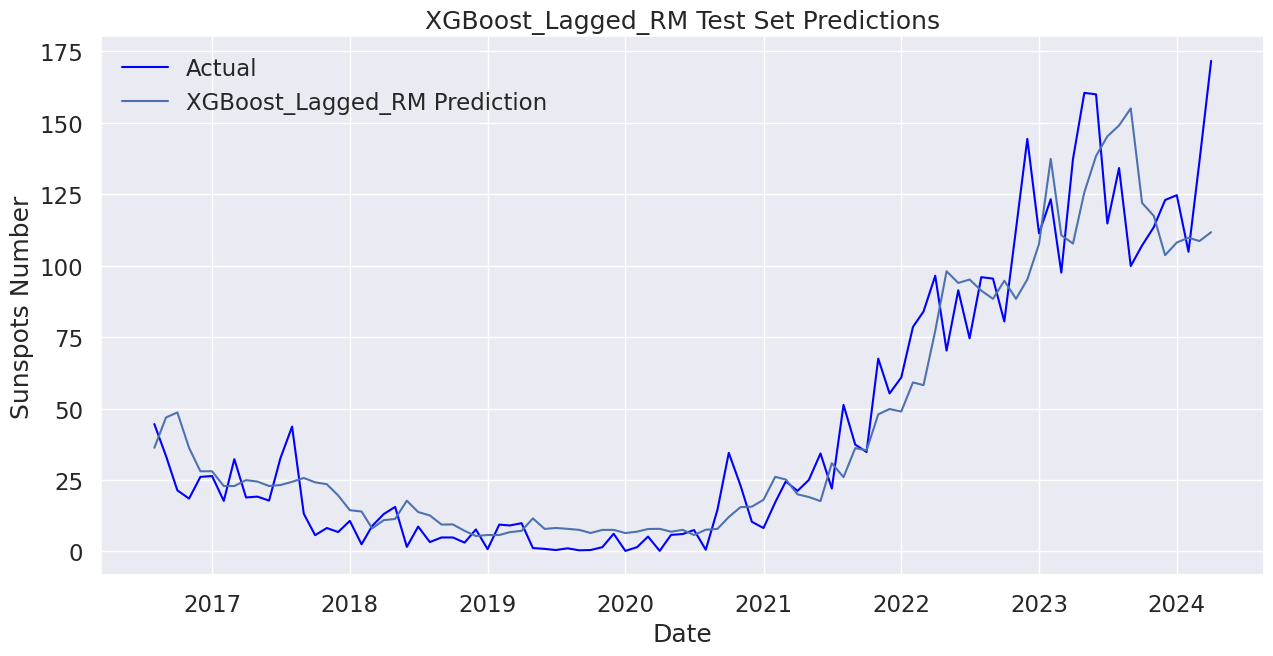

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 828, number of used features: 8
[LightGBM] [Info] Start training from score 98.923068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

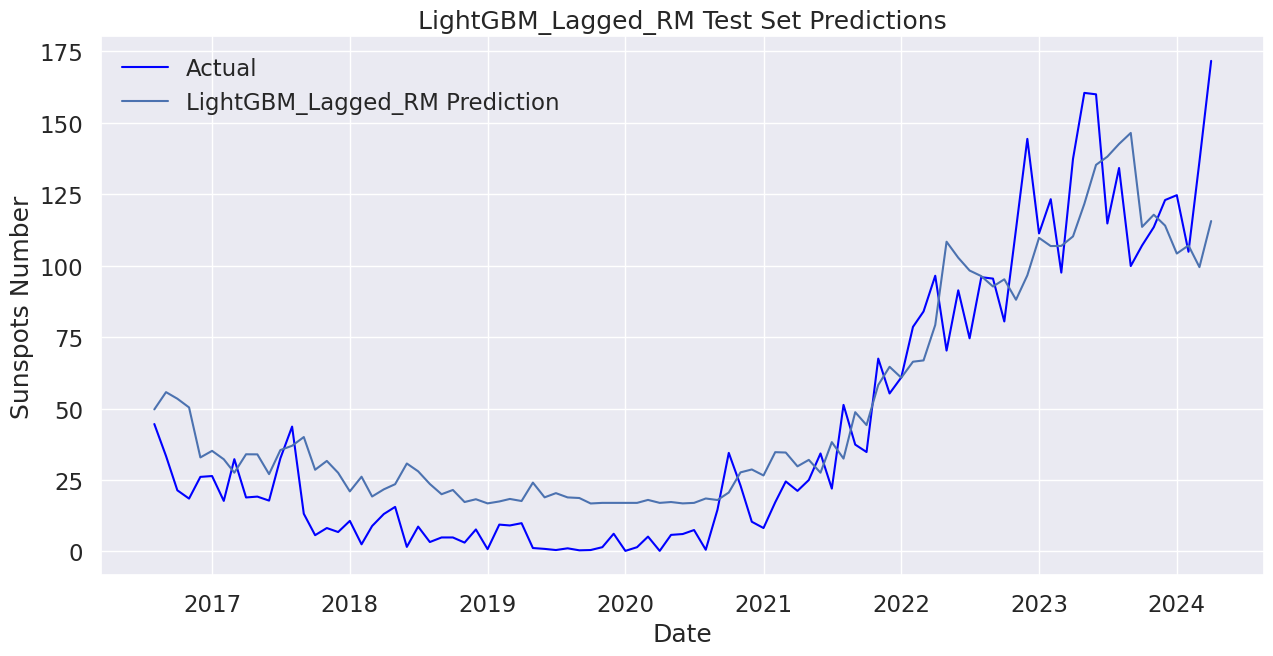


Best SVR_Lagged_RM Parameters:
{'C': 200, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
SVR_Lagged_RM Test Set Metrics:
MAE=10.578676187300381, MSE=224.79810211256301, RMSE=14.99326856000929, R2=0.902252468894315


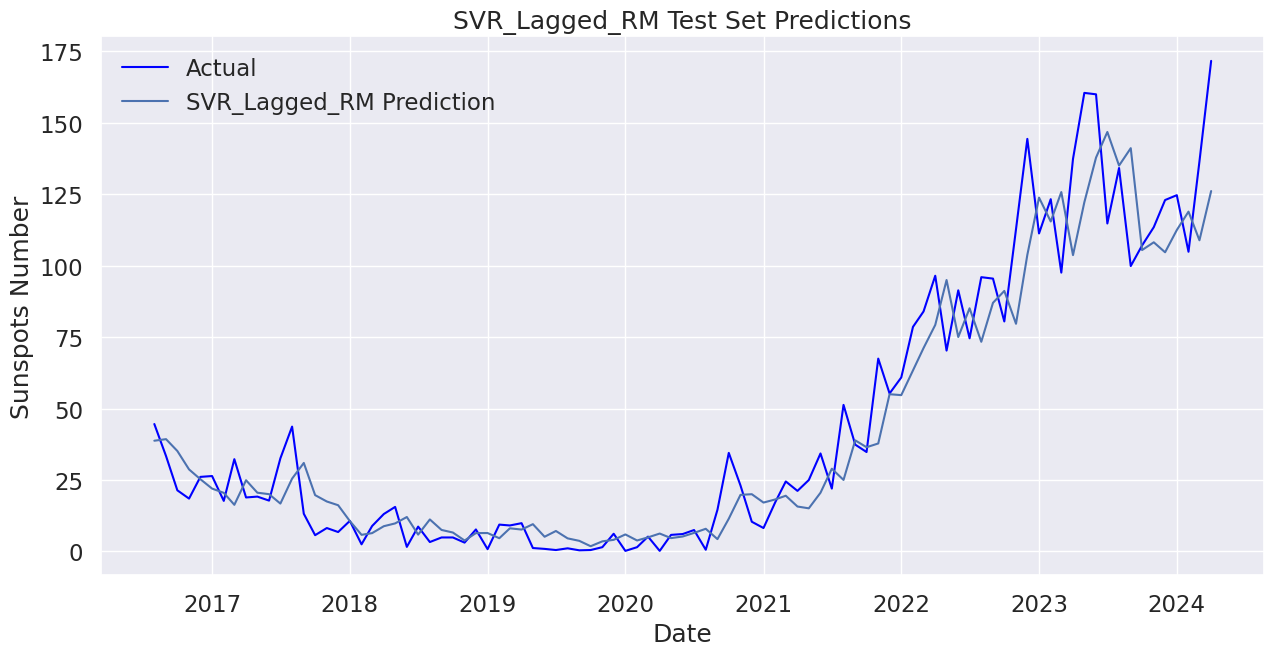

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Best RandomForest_Full_RM Parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
RandomForest_Full_RM Test Set Metrics:
MAE=12.044894169582935, MSE=287.5624014230888, RMSE=16.95766497555276, R2=0.8749610672253181


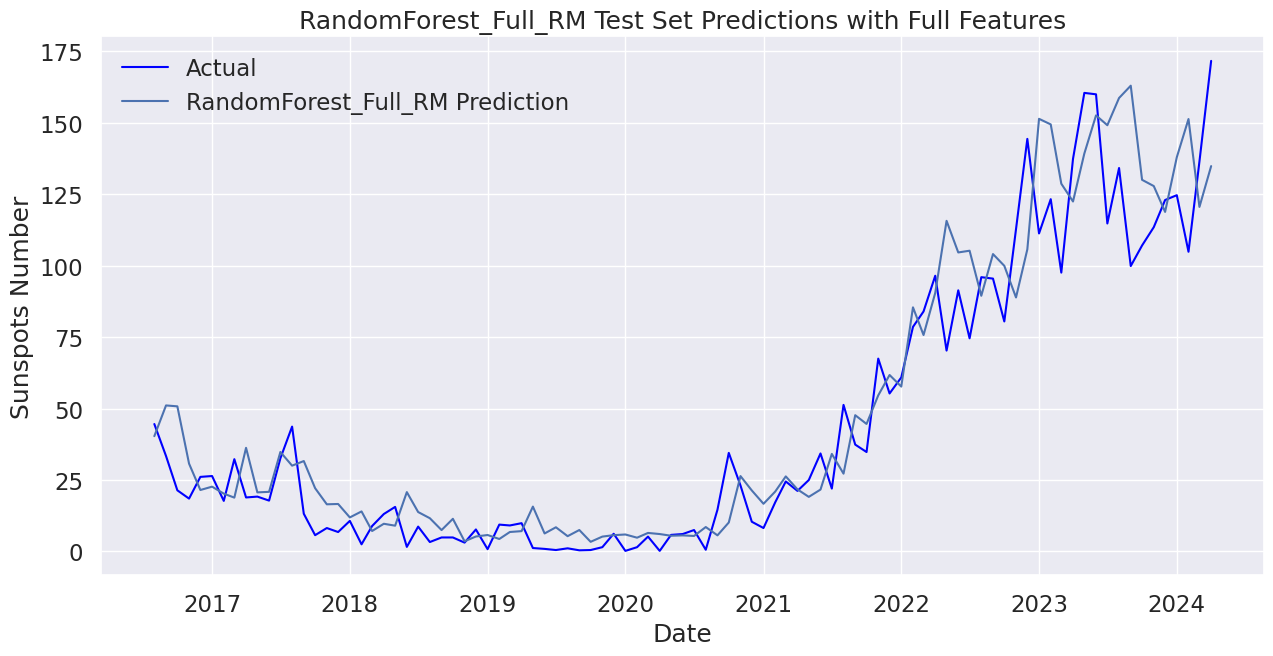


Best XGBoost_Full_RM Parameters:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
XGBoost_Full_RM Test Set Metrics:
MAE=17.197744820707587, MSE=378.4666680040786, RMSE=19.45421979941829, R2=0.835433742297924


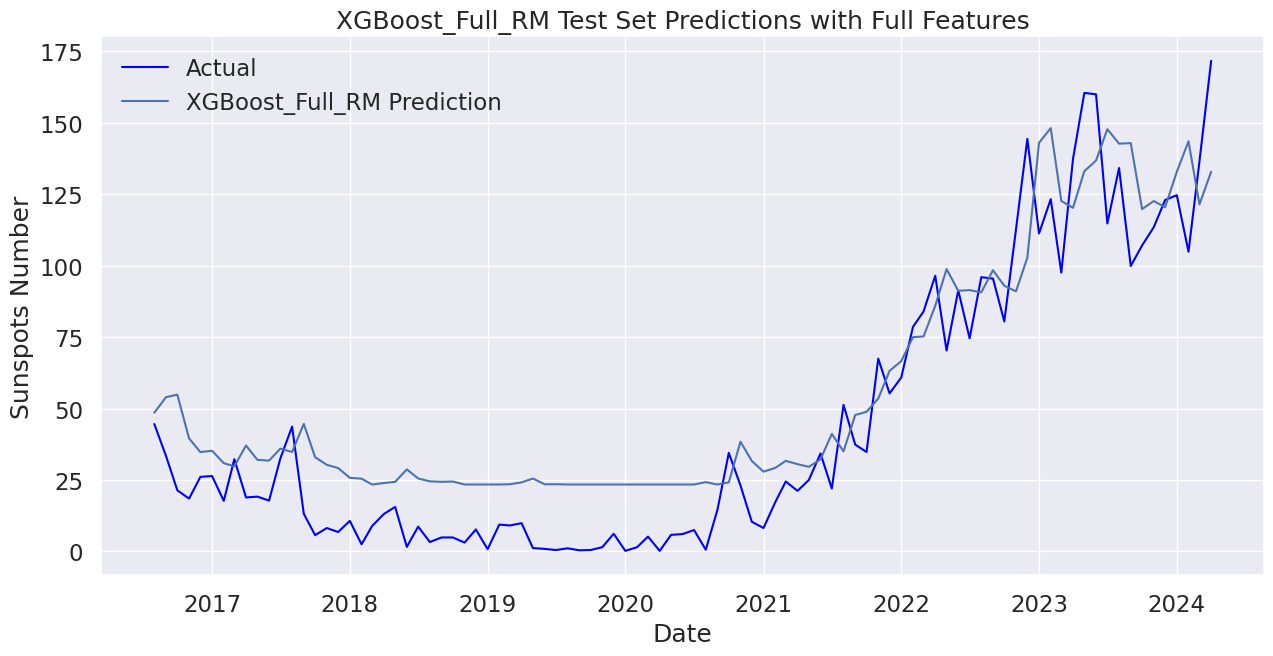

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 828, number of used features: 10
[LightGBM] [Info] Start training from score 98.923068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

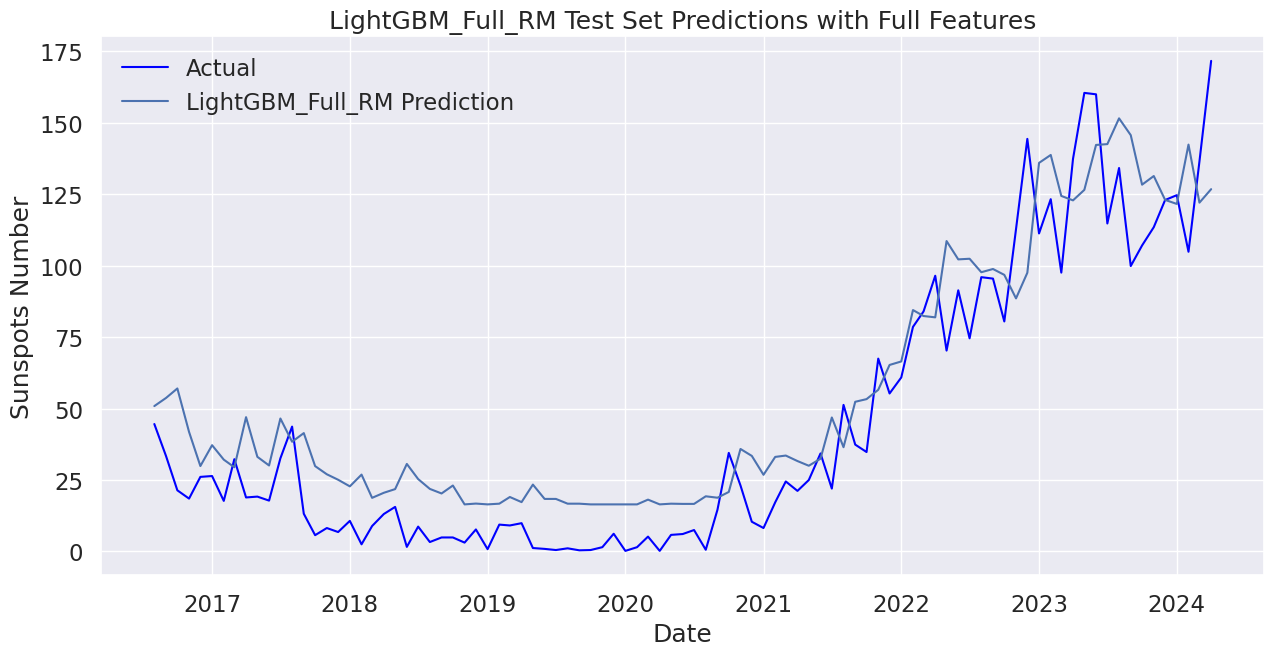


Best SVR_Full_RM Parameters:
{'C': 10, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
SVR_Full_RM Test Set Metrics:
MAE=11.82215730151727, MSE=231.48923025790788, RMSE=15.214770134902068, R2=0.8993430081365381


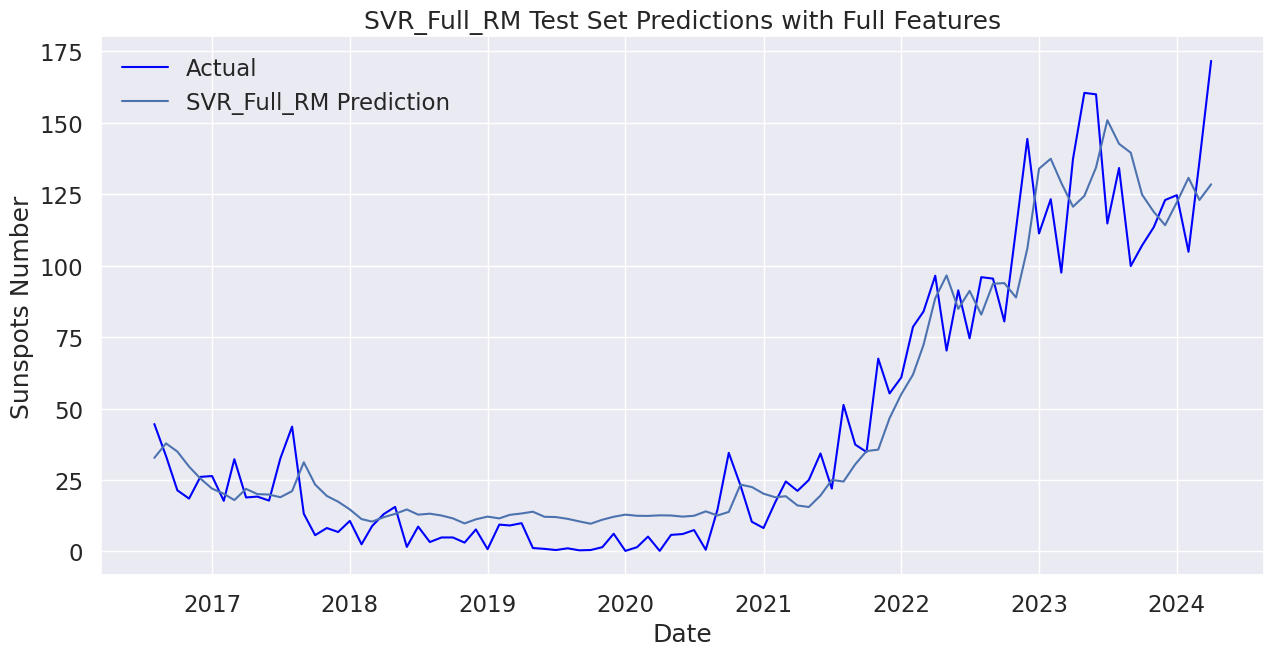

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.impute import SimpleImputer

# Load your data (assuming filtered_data is already loaded as a DataFrame)
# df = pd.read_csv('your_data.csv')  # Update this line as needed

# Add lagged features
def add_lagged_features(df, lags):
    for lag in lags:
        df[f'Sunspots_Number_Lag_{lag}'] = df['Sunspots_Number'].shift(lag)
    return df

# Define lagged values
lagged_values = [1, 2, 3, 4, 5, 6]  # Add more lags if needed

# Add lagged features to data
filtered_data = add_lagged_features(filtered_data, lagged_values)

# Set the target variable for one-step-ahead prediction
filtered_data['Sunspots_Number_Target'] = filtered_data['Sunspots_Number'].shift(-1)

# Drop rows with NaN values due to lagging and shifting
filtered_data = filtered_data.dropna()

# Define feature sets
lagged_features = [f'Sunspots_Number_Lag_{lag}' for lag in lagged_values]
full_features = lagged_features + ['F10.7obs', 'F10.7adj']

# Add rolling mean features
def add_rolling_means(df, windows):
    for window in windows:
        df.loc[:, f'Rolling_Mean_{window}'] = df['Sunspots_Number'].rolling(window=window).mean()
    return df

# Define rolling mean windows
rolling_windows = [3, 6]  # You can add more windows if needed

# Add rolling mean features to data
filtered_data = add_rolling_means(filtered_data, rolling_windows)

# Define the feature sets again including rolling means
lagged_features_with_rm = lagged_features + [f'Rolling_Mean_{window}' for window in rolling_windows]
full_features_with_rm = lagged_features_with_rm + ['F10.7obs', 'F10.7adj']

# Split data into train and test sets
train_size = int(len(filtered_data) * 0.9)  # 90% train, 10% test
train_data = filtered_data.iloc[:train_size]
test_data = filtered_data.iloc[train_size:]

# Prepare data for lagged features
X_train_lagged = train_data[lagged_features_with_rm]
y_train_lagged = train_data['Sunspots_Number_Target']
X_test_lagged = test_data[lagged_features_with_rm]
y_test_lagged = test_data['Sunspots_Number_Target']

# Handle NaN values
imputer = SimpleImputer(strategy='mean')
X_train_lagged = imputer.fit_transform(X_train_lagged)
X_test_lagged = imputer.transform(X_test_lagged)

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    return preds, mae, mse, rmse, r2

# Grid Search and Evaluation for Lagged Features with Rolling Mean
def grid_search_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, model_name):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    preds, mae, mse, rmse, r2 = evaluate_model(best_model, X_train, y_train, X_test, y_test)
    print(f"\nBest {model_name} Parameters:")
    print(grid_search.best_params_)
    print(f"{model_name} Test Set Metrics:")
    print(f"MAE={mae}, MSE={mse}, RMSE={rmse}, R2={r2}")
    return preds, mae, mse, rmse, r2, best_model

# Define parameter grids
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'max_features': ['auto'],
    'bootstrap': [True]
}
svr_param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100, 200],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto']
}
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'max_depth': [3, 5, 7]
}
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
lgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

# Train and evaluate models with lagged features and rolling mean
for model_name, model, param_grid in [
    ('RandomForest_Lagged_RM', RandomForestRegressor(random_state=42), rf_param_grid),
    ('XGBoost_Lagged_RM', XGBRegressor(random_state=42), xgb_param_grid),
    ('LightGBM_Lagged_RM', lgb.LGBMRegressor(random_state=42), lgb_param_grid),
    ('SVR_Lagged_RM', SVR(), svr_param_grid)
]:
    preds, mae, mse, rmse, r2, best_model = grid_search_and_evaluate(model, param_grid, X_train_lagged, y_train_lagged, X_test_lagged, y_test_lagged, model_name)
    plt.figure(figsize=(15, 7))
    plt.plot(test_data.index, y_test_lagged, label='Actual', color='blue')
    plt.plot(test_data.index, preds, label=f'{model_name} Prediction')
    plt.legend()
    plt.title(f'{model_name} Test Set Predictions')
    plt.xlabel('Date')
    plt.ylabel('Sunspots Number')
    plt.show()

# Prepare data for full features
X_train_full = train_data[full_features_with_rm]
y_train_full = train_data['Sunspots_Number_Target']
X_test_full = test_data[full_features_with_rm]
y_test_full = test_data['Sunspots_Number_Target']

# Handle NaN values
X_train_full = imputer.fit_transform(X_train_full)
X_test_full = imputer.transform(X_test_full)

# Train and evaluate models with full feature set
for model_name, model, param_grid in [
    ('RandomForest_Full_RM', RandomForestRegressor(random_state=42), rf_param_grid),
    ('XGBoost_Full_RM', XGBRegressor(random_state=42), xgb_param_grid),
    ('LightGBM_Full_RM', lgb.LGBMRegressor(random_state=42), lgb_param_grid),
    ('SVR_Full_RM', SVR(), svr_param_grid)
]:
    preds, mae, mse, rmse, r2, best_model = grid_search_and_evaluate(model, param_grid, X_train_full, y_train_full, X_test_full, y_test_full, model_name)
    plt.figure(figsize=(15, 7))
    plt.plot(test_data.index, y_test_full, label='Actual', color='blue')
    plt.plot(test_data.index, preds, label=f'{model_name} Prediction')
    plt.legend()
    plt.title(f'{model_name} Test Set Predictions with Full Features')
    plt.xlabel('Date')
    plt.ylabel('Sunspots Number')
    plt.show()
